In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import copy

In [2]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

### Constants

In [3]:
  #-------------   Table 7 --------------#
Ra = 287.0
Tim = 300.6186
Vim = 0.0220
Re = 286.0
Vem = 0.0200
Vd = 0.0127
ncyl = 6.0
gamma_a = 1.3964
cpa = 1011.0
cva = 724.0
rc = 17.0
xcv = 2.3371e-14
qHV = 42900000
dpipe = 0.1
lpipe = 1.0
npipe = 2.0
cpe = 1332.0
tegr1 = 0.05
tegr2 = 0.13
tdegr = 0.065
Kegr = 1.8
Pi_egropt = 0.6500
Jt = 2.0e-4
tvgt = 0.025
tdvgt = 0.04
cpe = 1332.0
gamma_e = 1.2734

Rt = 0.04
Rc = 0.0400
#----------   Table 9  -------------#
cvol1 = -2.0817e-4
cvol2 = -0.0034
cvol3 = 1.1497
cwpsi1 = 1.0882e-8
cwpsi2 = -1.7320e-4
cwpsi3 = 1.0286
pcopt = 1.0455
Wcopt = 0.2753
a1 = 3.0919
a2 = 2.1479
a3 = -2.4823
eta_cmax = 0.7364
cp = 0.2708
cegr1 = -1.1104e-4
cegr2 = 0.0178
cegr3 = 0.0
cwphi1 = -1.4298e-8
cwphi2 = -0.0015

cwphi3 = 29.6462
cm1 = 1.3563
cm2 = 2.7692e3
cm3 = 0.0100
BSRopt = 0.9755
eta_tm_max = 0.8180
cpsi2 = 0.0
cphi2 = 0.0
cvgt1 = 126.8719
cvgt2 = 117.1447
cf1 = 1.9480
cf2 = -0.7763
Kt = 2.8902

h_tm_max = 0.8180
#---------------True values of unknown parameters-----------------#
Aegrmax_true = 4.0e-4
eta_sc_true = 1.1015
htot_true = 96.2755
Avgtmax_true = 8.4558e-4
#---------------#
pi = np.pi
pamb = 1.0111e5
Tamb = 298.4636
#----Guesses----#
cpsi1 , cphi1 = 1.0, 1.0

# Loading Data for Surrogates Training

In [4]:
# Loading files 
df_empirical_data = pd.read_excel(r"C:\Users\dimka\Documents\Diesel Engine Model\Empirical Formulae Noisy 3%(2).xlsx")
df_analytical = pd.read_excel(r"C:\Users\dimka\Documents\Diesel Engine Model\Data\Analytical Functions.xlsx")

In [5]:
df_empirical_data

,Unnamed: 0,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,n_e,p_em,...,omegat,u_vgt,u_egr,W_ei,W_egr,T_em,W_t,W_c,T_c,domegat_dt
0,0,0.000000,0.952789,0.718679,0.074436,1.168552,0.204838,0.219423,1522.538679,101545.593240,...,5205.835059,58.833382,12.914975,0.178104,0.006414,860.323629,0.037847,0.269825,299.007612,-2648.482902
1,1,0.021919,0.949707,0.827573,0.467906,1.122659,0.199490,0.207864,1523.444543,130052.331412,...,5135.958342,43.234460,52.025143,0.190247,0.042876,855.035457,0.099109,0.255952,336.205413,-3896.687335
2,2,0.031917,0.948824,0.804754,0.458738,0.531727,0.332004,0.202650,1491.623902,130270.315603,...,5082.634346,40.046814,58.635516,0.199946,0.050997,835.136559,0.101189,0.248740,330.843305,-4631.779159
3,3,0.034242,0.948064,0.826212,0.428685,0.493646,0.342500,0.199855,1557.028739,139574.733454,...,5137.439483,37.141066,62.420646,0.203081,0.052625,849.271566,0.106544,0.245186,329.459403,-4551.330415
4,4,0.036566,0.947562,0.839523,0.497329,0.415815,0.404777,0.198324,1496.400824,137069.284128,...,5138.724330,39.343743,62.932384,0.197004,0.054992,846.056796,0.121238,0.239017,332.102475,-4190.392093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2195,59.850723,0.936154,0.546996,0.793716,0.587561,0.707379,0.149449,1558.636244,172297.995961,...,6970.989995,53.540947,40.597549,0.268998,0.025140,720.922932,0.254255,0.253905,360.722544,394.120026
2196,2196,59.867654,0.936634,0.543827,0.760014,0.598446,0.652748,0.151175,1542.116599,174444.290651,...,6910.929409,54.663667,40.084789,0.276190,0.028634,714.131868,0.252642,0.249684,363.085820,95.175386
2197,2197,59.896336,0.935644,0.540401,0.765953,0.548935,0.691024,0.152137,1553.846538,173864.858412,...,6907.652498,53.377715,38.658459,0.273066,0.027514,720.813344,0.259964,0.249241,362.044091,43.314175
2198,2198,59.936597,0.935188,0.569216,0.805253,0.600883,0.672693,0.152134,1460.421550,174688.823054,...,6967.741034,51.179647,34.983526,0.271149,0.025201,708.456877,0.260131,0.250464,360.743763,60.892391


### Normalizers

In [6]:
def normalize_with_train(data, train_data):
    min_val = train_data.min()
    max_val = train_data.max()
    
    """
    Normalizes a PyTorch tensor using training min and max.

    Args:
        tensor (torch.Tensor): Tensor to normalize (train or test).
        train_min (float): Minimum from training set.
        train_max (float): Maximum from training set.

    Returns:
        torch.Tensor: Normalized tensor.
    """
    return (data - min_val) / (max_val - min_val + 1e-8)

def denormalize_tensor_0_1(tensor, min_val, max_val):
    """
    Denormalizes a PyTorch tensor from the range [0, 1] to its original range.

    Args:
        tensor (torch.Tensor): Input tensor.
        min_val (float): Minimum value of the original tensor.
        max_val (float): Maximum value of the original tensor.

    Returns:
        torch.Tensor: Denormalized tensor.
    """
    return tensor * (max_val - min_val) + min_val

In [7]:
import numpy as np

def normalize_0_1(array):
    """
    Normalize a NumPy array to the range [0, 1].
    """
    min_val = np.min(array)
    max_val = np.max(array)
    return (array - min_val) / (max_val - min_val + 1e-8)  # add small epsilon to avoid division by zero


In [8]:
import numpy as np

def relative_L2_error(y_true, y_pred):
    """
    Compute the relative L2 error between true and predicted values.
    
    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
    
    Returns:
        float: Relative L2 error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    numerator = np.linalg.norm(y_true - y_pred, ord=2)
    denominator = np.linalg.norm(y_true, ord=2)
    
    return numerator / denominator


## Analytical Functions for Surrogates

In [9]:
eta_vol_analytical = df_analytical['eta_vol']
fegr_analytical = df_analytical['fegr']
F_vgt_Pi_t_analytical = df_analytical['F_vgt_Pi_t']
eta_c_analytical = df_analytical['eta_c']
eta_tm_analytical = df_analytical['eta_tm']
Phi_c_analytical  = df_analytical['Phi_c']

# Data Preprocessing

## Training - Testing - Evaluation Datasets

In [10]:
# Parameters
total_rows = len(df_empirical_data)
train_ratio = 0.75
test_ratio = 0.10
eval_ratio = 0.15

# Times to exclude from testing
times_to_exclude = set(np.round(np.arange(0, 60.01, 0.2), 8))

# Adding rounded time column for safer comparison
df_empirical_data['Time_rounded'] = df_empirical_data['Time'].round(8)

# Creating bins for time domain - tune bin width for granularity
bin_width = 5  # e.g., 5 units of time per bin, adjust as needed
time_min = df_empirical_data['Time'].min()
time_max = df_empirical_data['Time'].max()
bins = np.arange(time_min, time_max + bin_width, bin_width)

# Assigning each row to a time bin
df_empirical_data['time_bin'] = pd.cut(df_empirical_data['Time'], bins=bins, include_lowest=True)

# Preparing empty lists for split pieces
train_list = []
test_list = []
eval_list = []

# Processing each bin separately
for b in df_empirical_data['time_bin'].unique():

    bin_rows = df_empirical_data[df_empirical_data['time_bin'] == b]

    # Among bin_rows, we separate test-eligible and test-ineligible for testing split
    eval_eligible = bin_rows[~bin_rows['Time_rounded'].isin(times_to_exclude)]
    eval_ineligible = bin_rows[bin_rows['Time_rounded'].isin(times_to_exclude)]

    n_bin = len(bin_rows)
    n_train_bin = int(train_ratio * n_bin)
    n_test_bin = int(test_ratio * n_bin)
    n_eval_bin = n_bin - n_train_bin - n_test_bin

    # we make sure we don't pick more test samples than eligible
    n_eval_bin = min(n_eval_bin, len(eval_eligible))

    # we sample test from test_eligible
    eval_sample = eval_eligible.sample(n=n_eval_bin, random_state=42) if n_eval_bin > 0 else pd.DataFrame(columns=df_empirical_data.columns)

    # Removing test_sample from bin_rows to get remaining for train+val
    remaining = bin_rows.drop(eval_sample.index)

    # Now we sample val from remaining
    n_test_bin = min(n_test_bin, len(remaining))  # in case fewer rows left
    test_sample = remaining.sample(n=n_test_bin, random_state=42) if n_test_bin > 0 else pd.DataFrame(columns=df_empirical_data.columns)

    # Training sample is the rest
    train_sample = remaining.drop(test_sample.index)

    # we append to to lists
    train_list.append(train_sample)
    test_list.append(test_sample)
    eval_list.append(eval_sample)

# Concatenating all bins
df_empirical_data_training = pd.concat(train_list).sort_values(by='Time').reset_index(drop=True)
df_empirical_data_testing = pd.concat(test_list).sort_values(by='Time').reset_index(drop=True)
df_empirical_data_evaluation = pd.concat(eval_list).sort_values(by='Time').reset_index(drop=True)

# Droping helper columns
df_empirical_data_training = df_empirical_data_training.drop(columns=['Time_rounded', 'time_bin'])
df_empirical_data_testing = df_empirical_data_testing.drop(columns=['Time_rounded', 'time_bin'])
df_empirical_data_evaluation = df_empirical_data_evaluation.drop(columns=['Time_rounded', 'time_bin'])

# Datasets sizes
print(f"Training size: {len(df_empirical_data_training)}")
print(f"Testing size: {len(df_empirical_data_testing)}")
print(f"Evaluation size: {len(df_empirical_data_evaluation)}")

Training size: 1646
Testing size: 215
Evaluation size: 339


## Train - Test Split

In [11]:
# Combining training and testing datasets 
df_empirical_data = pd.concat([df_empirical_data_training, df_empirical_data_testing], ignore_index=True)

# sorting by time
df_empirical_data = df_empirical_data.sort_values(by='Time').reset_index(drop=True)

df_empirical_data

,Unnamed: 0,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,n_e,p_em,...,omegat,u_vgt,u_egr,W_ei,W_egr,T_em,W_t,W_c,T_c,domegat_dt
0,0,0.000000,0.952789,0.718679,0.074436,1.168552,0.204838,0.219423,1522.538679,101545.593240,...,5205.835059,58.833382,12.914975,0.178104,0.006414,860.323629,0.037847,0.269825,299.007612,-2648.482902
1,1,0.021919,0.949707,0.827573,0.467906,1.122659,0.199490,0.207864,1523.444543,130052.331412,...,5135.958342,43.234460,52.025143,0.190247,0.042876,855.035457,0.099109,0.255952,336.205413,-3896.687335
2,2,0.031917,0.948824,0.804754,0.458738,0.531727,0.332004,0.202650,1491.623902,130270.315603,...,5082.634346,40.046814,58.635516,0.199946,0.050997,835.136559,0.101189,0.248740,330.843305,-4631.779159
3,3,0.034242,0.948064,0.826212,0.428685,0.493646,0.342500,0.199855,1557.028739,139574.733454,...,5137.439483,37.141066,62.420646,0.203081,0.052625,849.271566,0.106544,0.245186,329.459403,-4551.330415
4,4,0.036566,0.947562,0.839523,0.497329,0.415815,0.404777,0.198324,1496.400824,137069.284128,...,5138.724330,39.343743,62.932384,0.197004,0.054992,846.056796,0.121238,0.239017,332.102475,-4190.392093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,2194,59.833792,0.936060,0.545195,0.805138,0.620458,0.713645,0.148368,1448.524221,172991.879588,...,7000.402738,54.355752,39.222930,0.272940,0.023087,716.868148,0.248158,0.252538,360.558115,-86.306532
1857,2195,59.850723,0.936154,0.546996,0.793716,0.587561,0.707379,0.149449,1558.636244,172297.995961,...,6970.989995,53.540947,40.597549,0.268998,0.025140,720.922932,0.254255,0.253905,360.722544,394.120026
1858,2196,59.867654,0.936634,0.543827,0.760014,0.598446,0.652748,0.151175,1542.116599,174444.290651,...,6910.929409,54.663667,40.084789,0.276190,0.028634,714.131868,0.252642,0.249684,363.085820,95.175386
1859,2198,59.936597,0.935188,0.569216,0.805253,0.600883,0.672693,0.152134,1460.421550,174688.823054,...,6967.741034,51.179647,34.983526,0.271149,0.025201,708.456877,0.260131,0.250464,360.743763,60.892391


In [12]:
# Target columns from the initial dataset
target_cols = ['eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'eta_tm_emp', 'eta_c_emp', 'Phi_c_emp']

# Input Dataset - Features
X = df_empirical_data.drop(columns=target_cols)

# Targets - Empirical Formulae
y = df_empirical_data[target_cols]

df_empirical_data_inputs = X
df_empirical_data_targets = y

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # 80% train, 20% test
    random_state=42  
)

df_empirical_data_inputs_training = X_train
df_empirical_data_inputs_testing = X_test

df_empirical_data_targets_training = y_train
df_empirical_data_targets_testing = y_test

## Time domains

In [14]:
time = df_analytical['Time']
time_train = X_train['Time'].to_numpy()
time_test = X_test['Time'].to_numpy()
time_eval = df_empirical_data_evaluation['Time'].to_numpy()

## Data from the whole time domain

In [15]:
print(df_empirical_data.columns.to_list())

['Unnamed: 0', 'Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']


In [16]:

columns = ['n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']
for col in columns:
    data = df_empirical_data[col].to_numpy()
    globals()[f"{col}_data"] = data
    globals()[f"{col}_data_tensor"] = torch.tensor(data, dtype=torch.float32).view(-1, 1)

pim_data = p_im_data
pem_data = p_em_data
ne_data = n_e_data
Tem_data = T_em_data
Wc_data = W_c_data

Pi_c_data = pim_data / pamb
Pi_t_data = pamb / pem_data
Pi_c_data_tensor = torch.tensor(Pi_c_data, dtype=torch.float32).view(-1, 1)
Pi_t_data_tensor = torch.tensor(Pi_t_data, dtype=torch.float32).view(-1, 1)

# Targets
target_columns = ['eta_vol_emp', 'eta_tm_emp', 'eta_c_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'Phi_c_emp']
for col in target_columns:
    data = df_empirical_data[col].to_numpy()
    globals()[f"{col}_data"] = data
    globals()[f"{col}_tensor"] = torch.tensor(data, dtype=torch.float32).view(-1, 1)

pim_data_tensor = p_im_data_tensor
pem_data_tensor = p_em_data_tensor
ne_data_tensor = n_e_data_tensor
Tem_data_tensor = T_em_data_tensor
Wc_data_tensor = W_c_data_tensor

In [17]:
df_empirical_data_inputs_training

,Unnamed: 0,Time,n_e,p_em,p_im,omegat,u_vgt,u_egr,W_ei,W_egr,T_em,W_t,W_c,T_c,domegat_dt
1216,1440,38.276950,1474.387655,189035.389037,180533.331328,7180.603681,41.501873,68.061014,0.303765,0.048530,685.478700,0.270481,0.249661,373.872921,145.841929
1074,1271,33.738074,1463.843231,174435.096186,169839.337927,6914.800051,50.422727,59.724175,0.287000,0.034882,700.801097,0.269250,0.255418,362.132216,-197.066615
1751,2073,56.400848,1494.783875,169093.298895,169016.973588,7427.637203,59.888372,48.761465,0.294671,0.020262,699.841868,0.273717,0.268737,367.279325,-389.796128
1231,1458,38.670318,1489.876009,186288.040986,175348.295860,7185.405424,46.332444,55.883739,0.301249,0.040538,688.431386,0.281175,0.259105,370.985300,-324.303643
1187,1406,37.450464,1454.296759,201937.859390,181140.338620,7163.933054,34.590373,75.419072,0.308193,0.065788,694.916289,0.249981,0.237363,368.917216,-232.105081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1336,35.400000,1476.066482,192935.336849,169522.514581,7093.242633,38.326590,82.612005,0.292347,0.057162,697.841531,0.242073,0.238921,363.072792,160.607389
1294,1531,40.297755,1581.041781,172955.666481,169332.861473,7190.798733,67.282314,36.706450,0.287192,0.011969,704.478507,0.279958,0.271411,364.556518,-1.727955
860,1023,27.425583,1572.205385,182485.407178,165649.172524,6747.901680,39.336852,63.299633,0.283693,0.053228,702.974966,0.245486,0.238293,365.599527,207.683698
1459,1729,46.520930,1597.885701,156018.974293,149589.474560,6770.684338,70.907064,30.255300,0.266010,0.014111,724.056573,0.265703,0.252100,350.405062,11.577592


## Training Data

In [18]:
# --- 1. Define Columns and Reference Tensors ---
input_cols = ['p_im', 'p_em', 'n_e', 'u_egr', 'u_vgt', 'omegat', 'T_em', 'W_c']
target_cols = ['eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'eta_tm_emp', 'eta_c_emp', 'Phi_c_emp']
reference_tensors = {
    'p_im': pim_data_tensor, 'p_em': pem_data_tensor, 'n_e': ne_data_tensor,
    'u_egr': u_egr_data_tensor, 'u_vgt': u_vgt_data_tensor, 'omegat': omegat_data_tensor,
    'T_em': Tem_data_tensor, 'W_c': Wc_data_tensor,
    'Pi_c': Pi_c_data_tensor, 'Pi_t': Pi_t_data_tensor,
}

# --- 2. Extract input and target data as numpy arrays ---
for col in input_cols:
    globals()[f"{col}_train"] = df_empirical_data_inputs_training[col].to_numpy()

pim_train = p_im_train
pem_train = p_em_train
ne_train = n_e_train
Tem_train = T_em_train
Wc_train = W_c_train

# Compute Pi_c and Pi_t
Pi_c_train = pim_train / pamb
Pi_t_train = pamb / pem_train

# --- 3. Convert input tensors and normalize them ---
for col in input_cols + ['Pi_c', 'Pi_t']:
    # Convert to tensor
    data = globals()[f"{col}_train"]
    tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1)
    globals()[f"{col}_train_tensor"] = tensor

    # Normalize using reference tensor
    ref_tensor = reference_tensors[col]
    norm_tensor = normalize_with_train(tensor, ref_tensor).view(-1, 1)
    globals()[f"{col}_train_norm_tensor"] = norm_tensor

# --- 4. Extract target data and convert to tensors ---
for col in target_cols:
    var_name = col.replace('_emp', '')
    globals()[f"{var_name}_train"] = df_empirical_data_targets_training[col].to_numpy()
    globals()[f"{var_name}_train_tensor"] = torch.tensor(globals()[f"{var_name}_train"], dtype=torch.float32).view(-1, 1)
    

pim_train_tensor = p_im_train_tensor
pem_train_tensor = p_em_train_tensor
ne_train_tensor = n_e_train_tensor
Tem_train_tensor = T_em_train_tensor
Wc_train_tensor = W_c_train_tensor

pim_train_norm_tensor = p_im_train_norm_tensor
pem_train_norm_tensor = p_em_train_norm_tensor
ne_train_norm_tensor = n_e_train_norm_tensor
Tem_train_norm_tensor = T_em_train_norm_tensor
Wc_train_norm_tensor = W_c_train_norm_tensor




## Testing Data

In [19]:
# --- 1. Define Columns and Reference Tensors ---
input_cols = ['p_im', 'p_em', 'n_e', 'u_egr', 'u_vgt', 'omegat', 'T_em', 'W_c']
target_cols = ['eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'eta_tm_emp', 'eta_c_emp', 'Phi_c_emp']
reference_tensors = {
    'p_im': pim_data_tensor, 'p_em': pem_data_tensor, 'n_e': ne_data_tensor,
    'u_egr': u_egr_data_tensor, 'u_vgt': u_vgt_data_tensor, 'omegat': omegat_data_tensor,
    'T_em': Tem_data_tensor, 'W_c': Wc_data_tensor,
    'Pi_c': Pi_c_data_tensor, 'Pi_t': Pi_t_data_tensor,
}

# --- 2. Extract input and target data as numpy arrays ---
for col in input_cols:
    globals()[f"{col}_test"] = df_empirical_data_inputs_testing[col].to_numpy()

pim_test = p_im_test
pem_test = p_em_test
ne_test = n_e_test
Tem_test = T_em_test
Wc_test = W_c_test

# Compute Pi_c and Pi_t
Pi_c_test = pim_test / pamb
Pi_t_test = pamb / pem_test

# --- 3. Convert input tensors and normalize them ---
for col in input_cols + ['Pi_c', 'Pi_t']:
    # Convert to tensor
    data = globals()[f"{col}_test"]
    tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1)
    globals()[f"{col}_test_tensor"] = tensor

    # Normalize using reference tensor
    ref_tensor = reference_tensors[col]
    norm_tensor = normalize_with_train(tensor, ref_tensor).view(-1, 1)
    globals()[f"{col}_test_norm_tensor"] = norm_tensor

# --- 4. Extract target data and convert to tensors ---
for col in target_cols:
    var_name = col.replace('_emp', '')
    globals()[f"{var_name}_test"] = df_empirical_data_targets_testing[col].to_numpy()
    globals()[f"{var_name}_test_tensor"] = torch.tensor(globals()[f"{var_name}_test"], dtype=torch.float32).view(-1, 1)
    

pim_test_tensor = p_im_test_tensor
pem_test_tensor = p_em_test_tensor
ne_test_tensor = n_e_test_tensor
Tem_test_tensor = T_em_test_tensor
Wc_test_tensor = W_c_test_tensor

pim_test_norm_tensor = p_im_test_norm_tensor
pem_test_norm_tensor = p_em_test_norm_tensor
ne_test_norm_tensor = n_e_test_norm_tensor
Tem_test_norm_tensor = T_em_test_norm_tensor
Wc_test_norm_tensor = W_c_test_norm_tensor

In [20]:
pim_data

array([101756.8630901 , 109634.94399731, 110551.59579568, ...,
       160283.13725449, 158248.48604248, 161883.49094705], shape=(1861,))

## Evaluation Data

In [21]:
# Input Dataset - Features
X_eval = df_empirical_data_evaluation.drop(columns=target_cols)

# Targets - Empirical Formulae
y_eval = df_empirical_data_evaluation[target_cols]

df_empirical_data_inputs_eval = X_eval
df_empirical_data_targets_eval = y_eval

In [22]:
# --- 2. Extract input and target data as numpy arrays ---
for col in input_cols:
    globals()[f"{col}_eval"] = df_empirical_data_inputs_eval[col].to_numpy()

pim_eval = p_im_eval
pem_eval = p_em_eval
ne_eval = n_e_eval
Tem_eval = T_em_eval
Wc_eval = W_c_eval

# Compute Pi_c and Pi_t
Pi_c_eval = pim_eval / pamb
Pi_t_eval = pamb / pem_eval

# --- 3. Convert input tensors and normalize them ---
for col in input_cols + ['Pi_c', 'Pi_t']:
    # Convert to tensor
    data = globals()[f"{col}_eval"]
    tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1)
    globals()[f"{col}_eval_tensor"] = tensor

    # Normalize using reference tensor
    ref_tensor = reference_tensors[col]
    norm_tensor = normalize_with_train(tensor, ref_tensor).view(-1, 1)
    globals()[f"{col}_eval_norm_tensor"] = norm_tensor

# --- 4. Extract target data and convert to tensors ---
for col in target_cols:
    var_name = col.replace('_emp', '')
    globals()[f"{var_name}_eval"] = df_empirical_data_targets_eval[col].to_numpy()
    globals()[f"{var_name}_eval_tensor"] = torch.tensor(globals()[f"{var_name}_eval"], dtype=torch.float32).view(-1, 1)
    

pim_eval_tensor = p_im_eval_tensor
pem_eval_tensor = p_em_eval_tensor
ne_eval_tensor = n_e_eval_tensor
Tem_eval_tensor = T_em_eval_tensor
Wc_eval_tensor = W_c_eval_tensor

pim_eval_norm_tensor = p_im_eval_norm_tensor
pem_eval_norm_tensor = p_em_eval_norm_tensor
ne_eval_norm_tensor = n_e_eval_norm_tensor
Tem_eval_norm_tensor = T_em_eval_norm_tensor
Wc_eval_norm_tensor = W_c_eval_norm_tensor

# Loading Clean Data for Empirical Formulae

## Training Data

In [23]:
eta_vol_train_clean = np.load('eta_vol_train_clean.npy')
fegr_train_clean = np.load('fegr_train_clean.npy')
F_vgt_Pi_t_train_clean = np.load('F_vgt_Pi_t_train_clean.npy')
eta_tm_train_clean = np.load('eta_tm_train_clean.npy')
eta_c_train_clean = np.load('eta_c_train_clean.npy')
Phi_c_train_clean = np.load('Phi_c_train_clean.npy')

# Converting training data to tensors
eta_vol_train_clean_tensor = torch.tensor(eta_vol_train_clean, dtype=torch.float32).view(-1, 1)
fegr_train_clean_tensor = torch.tensor(fegr_train_clean, dtype=torch.float32).view(-1, 1)
F_vgt_Pi_t_train_clean_tensor = torch.tensor(F_vgt_Pi_t_train_clean, dtype=torch.float32).view(-1, 1)
eta_tm_train_clean_tensor = torch.tensor(eta_tm_train_clean, dtype=torch.float32).view(-1, 1)
eta_c_train_clean_tensor = torch.tensor(eta_c_train_clean, dtype=torch.float32).view(-1, 1)
Phi_c_train_clean_tensor = torch.tensor(Phi_c_train_clean, dtype=torch.float32).view(-1, 1)

## Testing Data

In [24]:
eta_vol_test_clean = np.load('eta_vol_test_clean.npy')
fegr_test_clean = np.load('fegr_test_clean.npy')
F_vgt_Pi_t_test_clean = np.load('F_vgt_Pi_t_test_clean.npy')
eta_tm_test_clean = np.load('eta_tm_test_clean.npy')
eta_c_test_clean = np.load('eta_c_test_clean.npy')
Phi_c_test_clean = np.load('Phi_c_test_clean.npy')

# Converting testing data to tensors
eta_vol_test_clean_tensor = torch.tensor(eta_vol_test_clean, dtype=torch.float32).view(-1, 1)
fegr_test_clean_tensor = torch.tensor(fegr_test_clean, dtype=torch.float32).view(-1, 1)
F_vgt_Pi_t_test_clean_tensor = torch.tensor(F_vgt_Pi_t_test_clean, dtype=torch.float32).view(-1, 1)
eta_tm_test_clean_tensor = torch.tensor(eta_tm_test_clean, dtype=torch.float32).view(-1, 1)
eta_c_test_clean_tensor = torch.tensor(eta_c_test_clean, dtype=torch.float32).view(-1, 1)
Phi_c_test_clean_tensor = torch.tensor(Phi_c_test_clean, dtype=torch.float32).view(-1, 1)

## Evaluation Data

In [25]:
eta_vol_eval_clean = np.load('eta_vol_eval_clean.npy')
fegr_eval_clean = np.load('fegr_eval_clean.npy')
F_vgt_Pi_t_eval_clean = np.load('F_vgt_Pi_t_eval_clean.npy')
eta_tm_eval_clean = np.load('eta_tm_eval_clean.npy')
eta_c_eval_clean = np.load('eta_c_eval_clean.npy')
Phi_c_eval_clean = np.load('Phi_c_eval_clean.npy')

# Converting evaluation data to tensors
eta_vol_eval_clean_tensor = torch.tensor(eta_vol_eval_clean, dtype=torch.float32).view(-1, 1)
fegr_eval_clean_tensor = torch.tensor(fegr_eval_clean, dtype=torch.float32).view(-1, 1)
F_vgt_Pi_t_eval_clean_tensor = torch.tensor(F_vgt_Pi_t_eval_clean, dtype=torch.float32).view(-1, 1)
eta_tm_eval_clean_tensor = torch.tensor(eta_tm_eval_clean, dtype=torch.float32).view(-1, 1)
eta_c_eval_clean_tensor = torch.tensor(eta_c_eval_clean, dtype=torch.float32).view(-1, 1)
Phi_c_eval_clean_tensor = torch.tensor(Phi_c_eval_clean, dtype=torch.float32).view(-1, 1)

# Training the Surrogates

## $N_1^{(P)}(x; \theta_1^P) - \eta_{\mathit{vol}}$

### Training Process

In [26]:
# ---------------------------------------------
# 1. Defining the Pre-Trained Neural Network N1
# ---------------------------------------------
class FFNN1_PT(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

torch.manual_seed(123)
FFNN1_PT = FFNN1_PT(2, 1, 10)

# ---------------------------------
# 2. Loss Function & Optimizer
# ---------------------------------
def NN1_PT_loss(model, x1_data, x2_data, y_data):
    x_combined = torch.cat((x1_data, x2_data), dim=1)  # Concatenating inputs
    y_pred = model(x_combined)
    return torch.mean((y_data - y_pred)**2)

optimiser_N1_PT = optim.Adam(FFNN1_PT.parameters(), lr=0.0001)

# ---------------------------------
# 3. Training Loop
# ---------------------------------
num_epochs_N1_PT = 35000
print_every_N1_PT = 1000
early_stop_patience = 8000  # epochs to wait for improvement

train_losses_N1_PT = []
test_losses_N1_PT = []

# Learning rate scheduler
scheduler_PT1 = ReduceLROnPlateau(optimiser_N1_PT, mode='min', factor=0.5, patience=2000,  min_lr=1e-8)

best_test_loss = float('inf')
epochs_no_improve = 0


FFNN1_PT.train()
for epoch in range(num_epochs_N1_PT):
    optimiser_N1_PT.zero_grad()

    # Computing training loss
    train_loss_N1_PT = NN1_PT_loss(FFNN1_PT, pim_train_norm_tensor, ne_train_norm_tensor, eta_vol_train_tensor)
    train_losses_N1_PT.append(train_loss_N1_PT.item())

    train_loss_N1_PT.backward()
    optimiser_N1_PT.step()

    # Computing test loss (without backpropagation)
    FFNN1_PT.eval()
    with torch.no_grad():
        test_loss_N1_PT = NN1_PT_loss(FFNN1_PT, pim_test_norm_tensor, ne_test_norm_tensor, eta_vol_test_tensor)
        scheduler_PT1.step(test_loss_N1_PT)
        test_losses_N1_PT.append(test_loss_N1_PT.item())

    FFNN1_PT.train()  # Switch back to training mode

    if test_loss_N1_PT.item() < best_test_loss:
        best_test_loss = test_loss_N1_PT.item()
        epochs_no_improve = 0
        best_model_wts = FFNN1_PT.state_dict()
    else:
        epochs_no_improve += 1

    if (epoch+1) % print_every_N1_PT == 0:
        print(f"Epoch {epoch+1}/{num_epochs_N1_PT}, "
              f"Train Loss = {train_loss_N1_PT.item():.2e}, "
              f"Test Loss = {test_loss_N1_PT.item():.2e}")

    if epochs_no_improve >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}. No improvement for {early_stop_patience} epochs.")
        break

FFNN1_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best test loss: {best_test_loss:.2e}")

Epoch 1000/35000, Train Loss = 2.75e-02, Test Loss = 2.72e-02
Epoch 2000/35000, Train Loss = 4.79e-05, Test Loss = 2.83e-05
Epoch 3000/35000, Train Loss = 4.43e-05, Test Loss = 2.62e-05
Epoch 4000/35000, Train Loss = 3.95e-05, Test Loss = 2.32e-05
Epoch 5000/35000, Train Loss = 3.36e-05, Test Loss = 1.95e-05
Epoch 6000/35000, Train Loss = 2.72e-05, Test Loss = 1.58e-05
Epoch 7000/35000, Train Loss = 2.11e-05, Test Loss = 1.24e-05
Epoch 8000/35000, Train Loss = 1.59e-05, Test Loss = 9.58e-06
Epoch 9000/35000, Train Loss = 1.20e-05, Test Loss = 7.64e-06
Epoch 10000/35000, Train Loss = 9.88e-06, Test Loss = 6.95e-06
Epoch 11000/35000, Train Loss = 8.78e-06, Test Loss = 6.67e-06
Epoch 12000/35000, Train Loss = 7.73e-06, Test Loss = 6.02e-06
Epoch 13000/35000, Train Loss = 6.52e-06, Test Loss = 5.10e-06
Epoch 14000/35000, Train Loss = 5.27e-06, Test Loss = 4.13e-06
Epoch 15000/35000, Train Loss = 4.11e-06, Test Loss = 3.25e-06
Epoch 16000/35000, Train Loss = 3.15e-06, Test Loss = 2.53e-06
E

### Train vs Validation Loss

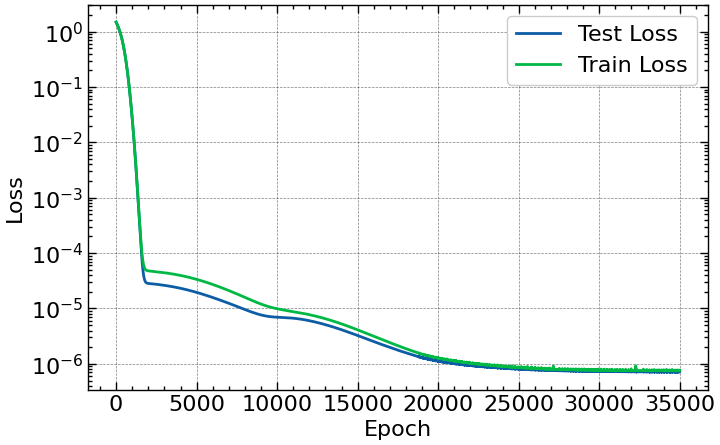

In [27]:
# ---------------------------------
# 4. Ploting Train vs Test Loss
# ---------------------------------
plt.figure(figsize=(8, 5))
plt.yscale("log")
plt.plot(np.linspace(0, len(test_losses_N1_PT), len(test_losses_N1_PT)), test_losses_N1_PT, label="Test Loss")
plt.plot(np.linspace(0, len(train_losses_N1_PT), len(train_losses_N1_PT)), train_losses_N1_PT, label="Train Loss")
plt.xticks(ticks=range(0, len(train_losses_N1_PT)+1, 5000))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation & Metrics

In [28]:
# ---------------------------------
# 5. Evaluating the Trained Model
# ---------------------------------
FFNN1_PT.eval()

with torch.no_grad():
    eta_vol_train_pred = FFNN1_PT(torch.cat((pim_train_norm_tensor, ne_train_norm_tensor), dim=1)).numpy()
    eta_vol_test_pred = FFNN1_PT(torch.cat((pim_test_norm_tensor, ne_test_norm_tensor), dim=1)).numpy()
    eta_vol_eval_pred = FFNN1_PT(torch.cat((pim_eval_norm_tensor, ne_eval_norm_tensor), dim=1)).detach().numpy()

y_train_true_eta_vol = eta_vol_train_clean_tensor.numpy()
y_test_true_eta_vol = eta_vol_test_clean_tensor.numpy()
y_eval_true_eta_vol = eta_vol_eval_clean_tensor.numpy()

train_l2_eta_vol = relative_L2_error(y_train_true_eta_vol, eta_vol_train_pred)
train_r2_eta_vol = r2_score(y_train_true_eta_vol, eta_vol_train_pred)
train_mse_eta_vol = mean_squared_error(y_train_true_eta_vol, eta_vol_train_pred)

test_l2_eta_vol = relative_L2_error(y_test_true_eta_vol, eta_vol_test_pred)
test_r2_eta_vol = r2_score(y_test_true_eta_vol, eta_vol_test_pred)
test_mse_eta_vol = mean_squared_error(y_test_true_eta_vol, eta_vol_test_pred)

eval_l2_eta_vol = relative_L2_error(y_eval_true_eta_vol, eta_vol_eval_pred)
eval_r2_eta_vol = r2_score(y_eval_true_eta_vol, eta_vol_eval_pred)
eval_mse_eta_vol = mean_squared_error(y_eval_true_eta_vol, eta_vol_eval_pred)

print(f"\n Metrics for eta_vol:")
print(f"Train: R² = {train_r2_eta_vol:.4f}, MSE = {train_mse_eta_vol:.2e}, L2={train_l2_eta_vol:.2e}")
print(f"Test:  R² = {test_r2_eta_vol:.4f}, MSE = {test_mse_eta_vol:.2e}, L2={test_l2_eta_vol:.2e}")
print(f"Eval:  R² = {eval_r2_eta_vol:.4f}, MSE = {eval_mse_eta_vol:.2e}, L2={eval_l2_eta_vol:.2e}")


 Metrics for eta_vol:
Train: R² = 0.9501, MSE = 3.79e-07, L2=6.59e-04
Test:  R² = 0.9318, MSE = 3.83e-07, L2=6.62e-04
Eval:  R² = 0.9477, MSE = 4.16e-07, L2=6.90e-04


### Plotting the results

C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\261056464.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, eta_vol_eval_pred, 'k--', color = 'red',  label='Prediction')


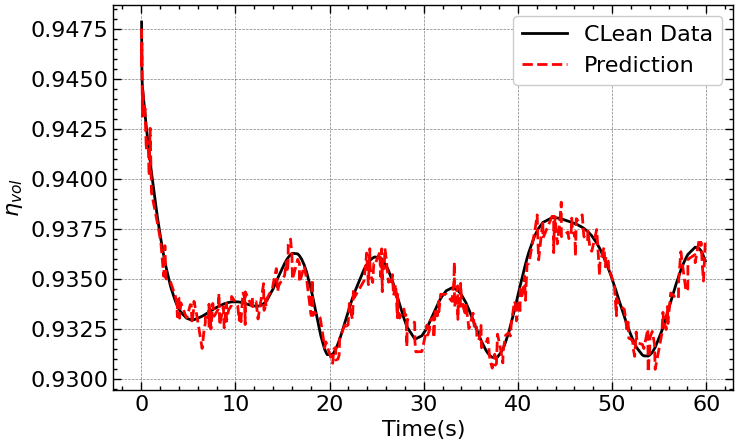

In [29]:
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(time_eval, eta_vol_eval_clean, color = 'black', label='CLean Data')
plt.plot(time_eval, eta_vol_eval_pred, 'k--', color = 'red',  label='Prediction')
plt.xlabel('Time(s)')
plt.ylabel(r'$\eta_{vol}$')
plt.legend()
plt.grid(True)
plt.show()

## $N_2^{(P)}(x; \theta_2^P) - f_{\mathit{egr}}$

### Training Process

In [30]:
# -------------------------------------------------
# 1. Defining the Pre-Trained Neural Network FFNN2
# ------------------------------------------------
class FFNN2(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Sigmoid()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        x = self.output_transformation(x)
        return x

torch.manual_seed(123)
FFNN2_PT = FFNN2(1, 1, 32)
# ---------------------------------
# 2. Loss Function & Optimizer
# ---------------------------------
def NN2_PT_loss(model, x_data, y_data):
    y_pred = model(x_data)
    return torch.mean((y_data - y_pred) ** 2)

optimiser_N2_PT = optim.Adam(FFNN2_PT.parameters(), lr=0.0001)

#----------------------------
# 3. Training Loop
#----------------------------
num_epochs_N2_PT = 10000
print_every_N2_PT = 1000
early_stop_patience_N2_PT = 5000  # epochs to wait for improvement

train_losses_N2_PT = []
test_losses_N2_PT = []

# Learning rate scheduler
scheduler_PT2 = ReduceLROnPlateau(optimiser_N2_PT, mode='min', factor=0.5, patience=2000,  min_lr=1e-8)

best_test_loss = float('inf')
epochs_no_improve = 0

FFNN2_PT.train()
for epoch in range(num_epochs_N2_PT):
    optimiser_N2_PT.zero_grad()

    train_loss = NN2_PT_loss(FFNN2_PT, u_egr_train_norm_tensor, fegr_train_tensor)
    train_losses_N2_PT.append(train_loss.item())
    train_loss.backward()
    optimiser_N2_PT.step()

    # Evaluation
    FFNN2_PT.eval()
    with torch.no_grad():
        test_loss_N2_PT = NN2_PT_loss(FFNN2_PT, u_egr_test_norm_tensor, fegr_test_tensor)
        scheduler_PT2.step(test_loss_N2_PT)
        test_losses_N2_PT.append(test_loss_N2_PT.item())

    FFNN2_PT.train() # Switching back to training mode


    # Early stopping logic
    if test_loss_N2_PT.item() < best_test_loss:
        best_test_loss = test_loss_N2_PT.item()
        epochs_no_improve = 0
        best_model_wts = FFNN2_PT.state_dict()
    else:
        epochs_no_improve += 1
    # progress
    if (epoch+1) % print_every_N2_PT == 0:
        print(f"Epoch {epoch+1}/{num_epochs_N2_PT}, "
              f"Train Loss = {train_loss.item():.2e}, "
              f"Test Loss = {test_loss_N2_PT.item():.2e}")

    if epochs_no_improve >= early_stop_patience_N2_PT:
        print(f"\nEarly stopping at epoch {epoch+1}. No improvement for {early_stop_patience_N2_PT} epochs.")
        break

FFNN2_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best test loss: {best_test_loss:.2e}")

Epoch 1000/10000, Train Loss = 1.04e-03, Test Loss = 8.18e-04
Epoch 2000/10000, Train Loss = 9.89e-04, Test Loss = 7.48e-04
Epoch 3000/10000, Train Loss = 9.74e-04, Test Loss = 7.22e-04
Epoch 4000/10000, Train Loss = 9.72e-04, Test Loss = 7.22e-04
Epoch 5000/10000, Train Loss = 9.70e-04, Test Loss = 7.24e-04
Epoch 6000/10000, Train Loss = 9.69e-04, Test Loss = 7.25e-04
Epoch 7000/10000, Train Loss = 9.68e-04, Test Loss = 7.26e-04
Epoch 8000/10000, Train Loss = 9.67e-04, Test Loss = 7.26e-04

Early stopping at epoch 8432. No improvement for 5000 epochs.
Training complete. Best test loss: 7.21e-04


### Training vs Validation Loss 

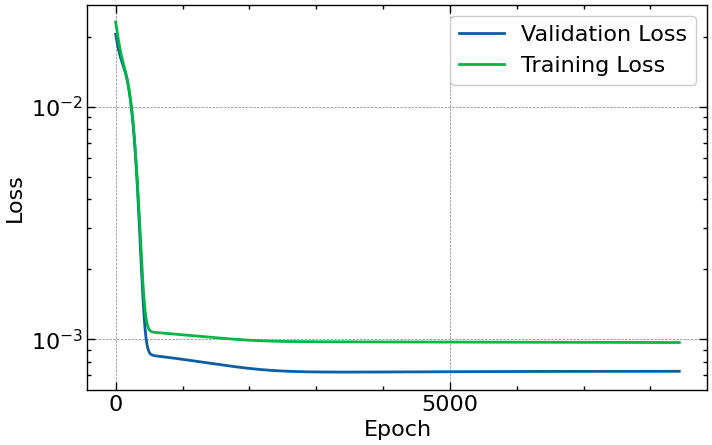

In [31]:
# -----------------------------------
# 4. Ploting Train vs Validation Loss
# -----------------------------------
plt.figure(figsize=(8, 5))
plt.yscale("log")
plt.plot(np.linspace(0, len(test_losses_N2_PT), len(test_losses_N2_PT)), test_losses_N2_PT, label="Validation Loss")
plt.plot(np.linspace(0, len(train_losses_N2_PT), len(train_losses_N2_PT)), train_losses_N2_PT, label="Training Loss")
plt.xticks(ticks=range(0, len(test_losses_N2_PT)+1, 5000))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation & Metrics

In [32]:
# ---------------------------------
# 5. Evaluating the Trained Model
# ---------------------------------
FFNN2_PT.eval()

with torch.no_grad():
    fegr_train_pred = FFNN2_PT(u_egr_train_norm_tensor).numpy()
    fegr_eval_pred = FFNN2_PT(u_egr_eval_norm_tensor).numpy()
    fegr_test_pred = FFNN2_PT(u_egr_test_norm_tensor).numpy()

y_train_true_fegr = fegr_train_clean_tensor.numpy()
y_val_true_fegr = fegr_eval_clean_tensor.numpy()
y_test_true_fegr = fegr_test_clean_tensor.numpy()

train_l2_fegr = relative_L2_error(fegr_train_pred, y_train_true_fegr)
train_r2_fegr = r2_score(y_train_true_fegr, fegr_train_pred)
train_mse_fegr = mean_squared_error(y_train_true_fegr, fegr_train_pred)

eval_l2_fegr = relative_L2_error(fegr_eval_pred, y_val_true_fegr)
eval_r2_fegr = r2_score(y_val_true_fegr, fegr_eval_pred)
eval_mse_fegr = mean_squared_error(y_val_true_fegr, fegr_eval_pred)

test_l2_fegr = relative_L2_error(fegr_test_pred, y_test_true_fegr)
test_r2_fegr = r2_score(y_test_true_fegr, fegr_test_pred)
test_mse_fegr = mean_squared_error(y_test_true_fegr, fegr_test_pred)

print(f"\n Metrics for fegr:")
print(f"Training: R² = {train_r2_fegr:.4f}, MSE = {train_mse_fegr:.2e}, L2 = {train_l2_fegr:.4f}")
print(f"Testing:  R² = {test_r2_fegr:.4f}, MSE = {test_mse_fegr:.2e}, L2 = {test_l2_fegr:.4f} ")
print(f"Evaluation:  R² = {eval_r2_fegr:.4f}, MSE = {eval_mse_fegr:.2e}, L2 = {eval_l2_fegr:.4f}")


 Metrics for fegr:
Training: R² = 0.9588, MSE = 7.35e-04, L2 = 0.0435
Testing:  R² = 0.9729, MSE = 4.78e-04, L2 = 0.0360 
Evaluation:  R² = 0.9704, MSE = 5.41e-04, L2 = 0.0372


C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\4254603884.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, fegr_eval_pred, 'k--', color = 'red',  label='Prediction')


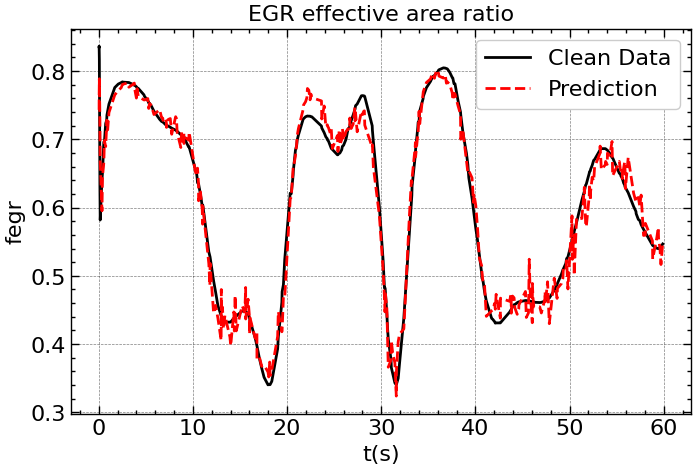

In [33]:
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(time_eval, fegr_eval_clean, color = 'black', label='Clean Data')
plt.plot(time_eval, fegr_eval_pred, 'k--', color = 'red',  label='Prediction')
plt.xlabel('t(s)')
plt.ylabel('fegr')
plt.title("EGR effective area ratio")
plt.legend()
plt.grid(True)
plt.show()

## $N_3^{(P)}(x; \theta_3^P) - F_{\mathit{vgt,Π_t}}$

### Training Process

In [34]:
#---------------------------------------------------
# 1. Defining the Pre-Trained Neural Network FFNN3
#---------------------------------------------------

class FFNN3(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Sigmoid()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        x = self.output_transformation(x)
        return x

torch.manual_seed(123)
FFNN3_PT = FFNN3(2, 1, 4)

#------------------------------------------
# 4. Loss Function & Optimiser
#------------------------------------------
def NN3_PT_loss(model, x1_data, x2_data, y_data):
    x_combined = torch.cat((x1_data, x2_data), dim=1)  # Concatenating inputs
    y_pred = model(x_combined)
    return torch.mean((y_data - y_pred)**2)

optimiser_N3_PT = optim.Adam(FFNN3_PT.parameters(), lr=0.0005)

#-----------------------------------
# 5. Training Loop
#-----------------------------------
num_epochs_N3_PT = 22000
print_every_N3_PT = 1000
early_stop_patience_N3_PT = 300  # epochs to wait for improvement

train_losses_N3_PT = []
test_losses_N3_PT = []

# Learning rate scheduler
scheduler_PT3 = ReduceLROnPlateau(optimiser_N3_PT, mode='min', factor=0.1, patience=2000, threshold=1e-5, min_lr=1e-8)

best_test_loss = float('inf')
epochs_no_improve = 0

FFNN3_PT.train()
for epoch in range(num_epochs_N3_PT):
    optimiser_N3_PT.zero_grad()
    train_loss_NN3_PT = NN3_PT_loss(FFNN3_PT, u_vgt_train_norm_tensor, Pi_t_train_norm_tensor, F_vgt_Pi_t_train_tensor)
    train_losses_N3_PT.append(train_loss_NN3_PT.item())
    train_loss_NN3_PT.backward()
    optimiser_N3_PT.step()

    FFNN3_PT.eval()
    with torch.no_grad():
        test_loss_NN3_PT = NN3_PT_loss(FFNN3_PT, u_vgt_test_norm_tensor, Pi_t_test_norm_tensor, F_vgt_Pi_t_test_tensor)
        scheduler_PT3.step(test_loss_NN3_PT)
        test_losses_N3_PT.append(test_loss_NN3_PT.item())
        
    FFNN3_PT.train()  # Switch back to training mode

    # Early stopping logic
    if test_loss_NN3_PT.item() < best_test_loss:
        best_test_loss = test_loss_NN3_PT.item()
        epochs_no_improve = 0
        best_model_wts = FFNN3_PT.state_dict()
    else:
        epochs_no_improve += 1

    # progress
    if (epoch+1) % print_every_N3_PT == 0:
        print(f"Epoch {epoch+1}/{num_epochs_N3_PT}, "
              f"Train Loss = {train_loss_NN3_PT.item():.2e}, "
              f"Test Loss = {test_loss_NN3_PT.item():.2e}")
        
    if epochs_no_improve >= early_stop_patience_N3_PT:
        print(f"\nEarly stopping at epoch {epoch+1}. No improvement for {early_stop_patience_N3_PT} epochs.")
        break

FFNN3_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best validation loss: {best_test_loss:.2e}")

Epoch 1000/22000, Train Loss = 6.58e-03, Test Loss = 6.16e-03
Epoch 2000/22000, Train Loss = 5.90e-03, Test Loss = 5.13e-03
Epoch 3000/22000, Train Loss = 3.99e-03, Test Loss = 3.29e-03
Epoch 4000/22000, Train Loss = 1.09e-03, Test Loss = 7.56e-04
Epoch 5000/22000, Train Loss = 9.21e-04, Test Loss = 6.83e-04
Epoch 6000/22000, Train Loss = 8.44e-04, Test Loss = 6.51e-04
Epoch 7000/22000, Train Loss = 7.99e-04, Test Loss = 6.31e-04
Epoch 8000/22000, Train Loss = 7.80e-04, Test Loss = 6.21e-04
Epoch 9000/22000, Train Loss = 7.69e-04, Test Loss = 6.19e-04

Early stopping at epoch 9291. No improvement for 300 epochs.
Training complete. Best validation loss: 6.19e-04


### Training vs Validation Loss

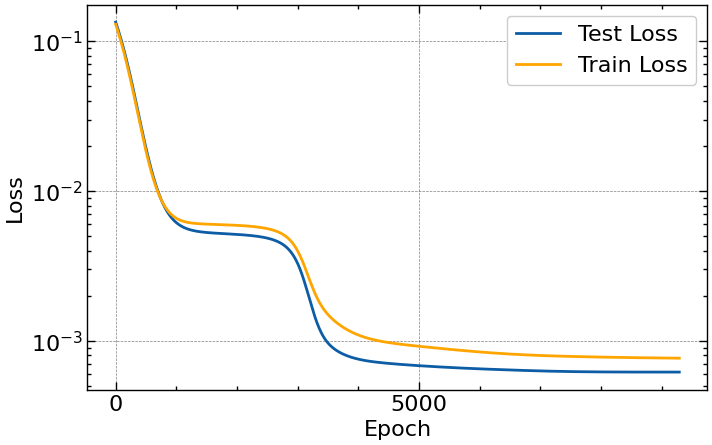

In [35]:
# ---------------------------------
# 4. Ploting Train vs Test Loss
# ---------------------------------
plt.figure(figsize=(8, 5))
plt.yscale("log")
plt.plot(np.linspace(0, len(test_losses_N3_PT), len(test_losses_N3_PT)), test_losses_N3_PT, label="Test Loss")
plt.plot(np.linspace(0, len(train_losses_N3_PT), len(train_losses_N3_PT)), train_losses_N3_PT, label="Train Loss", color = "orange")
plt.xticks(ticks=range(0, len(test_losses_N3_PT)+1, 5000))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation & Metrics

In [36]:
#------------------------------------
# 5. Evaluating the model
#------------------------------------

FFNN3_PT.eval()

with torch.no_grad():
    fvgt_Pit_train_pred = FFNN3_PT(torch.cat((u_vgt_train_norm_tensor, Pi_t_train_norm_tensor), dim=1)).numpy()
    fvgt_Pit_test_pred = FFNN3_PT(torch.cat((u_vgt_test_norm_tensor, Pi_t_test_norm_tensor), dim=1)).numpy()
    fvgt_Pit_eval_pred = FFNN3_PT(torch.cat((u_vgt_eval_norm_tensor, Pi_t_eval_norm_tensor), dim=1)).numpy()

y_train_true_fvgt_Pit = F_vgt_Pi_t_train_clean
y_test_true_fvgt_Pit = F_vgt_Pi_t_test_clean
y_eval_true_fvgt_Pit = F_vgt_Pi_t_eval_clean

train_l2_fvgt_Pit = relative_L2_error(fvgt_Pit_train_pred, y_train_true_fvgt_Pit)   
train_r2_fvgt_Pit = r2_score(y_train_true_fvgt_Pit, fvgt_Pit_train_pred)
train_mse_fvgt_Pit = mean_squared_error(y_train_true_fvgt_Pit, fvgt_Pit_train_pred)

test_l2_fvgt_Pit = relative_L2_error(fvgt_Pit_test_pred, y_test_true_fvgt_Pit)
test_r2_fvgt_Pit = r2_score(y_test_true_fvgt_Pit, fvgt_Pit_test_pred)
test_mse_fvgt_Pit = mean_squared_error(y_test_true_fvgt_Pit, fvgt_Pit_test_pred)

eval_l2_fvgt_Pit = relative_L2_error(fvgt_Pit_eval_pred, y_eval_true_fvgt_Pit)
eval_r2_fvgt_Pit = r2_score(y_eval_true_fvgt_Pit, fvgt_Pit_eval_pred)
eval_mse_fvgt_Pit = mean_squared_error(y_eval_true_fvgt_Pit, fvgt_Pit_eval_pred)


print(f"\n Metrics for fvgt_Pit:")
print(f"Training: R² = {train_r2_fvgt_Pit:.4f}, MSE = {train_mse_fvgt_Pit:.2e}, L2 = {train_l2_fvgt_Pit:.4f}")
print(f"Testing:  R² = {test_r2_fvgt_Pit:.4f}, MSE = {test_mse_fvgt_Pit:.2e}, L2 = {test_l2_fvgt_Pit:.4f}")
print(f"Evaluation: R² = {eval_r2_fvgt_Pit:.4f}, MSE = {eval_mse_fvgt_Pit:.2e}, L2 = {eval_l2_fvgt_Pit:.4f}")


 Metrics for fvgt_Pit:
Training: R² = 0.9691, MSE = 1.71e-04, L2 = 3.6163
Testing:  R² = 0.9723, MSE = 1.29e-04, L2 = 1.6421
Evaluation: R² = 0.9582, MSE = 2.20e-04, L2 = 1.6920


C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\1933556915.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, fvgt_Pit_eval_pred, 'k--', color =  'red',  label='Prediction')


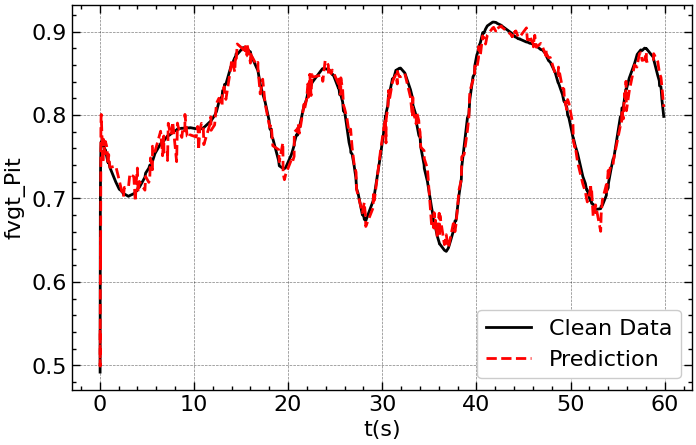

In [37]:
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(time_eval, F_vgt_Pi_t_eval_clean, color = 'black', label='Clean Data')
plt.plot(time_eval, fvgt_Pit_eval_pred, 'k--', color =  'red',  label='Prediction')
plt.xlabel('t(s)')
plt.ylabel('fvgt_Pit')
plt.legend()
plt.grid(True)
plt.show()

## $N_4^{(P)}(x; \theta_4^P) - \eta_{\mathit{tm}}$

### Training Process

In [38]:
#--------------------------------------------------
# 1. Defining the Pre-Trained Neural Network N4
#--------------------------------------------------
class FFNN4(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        return x

torch.manual_seed(123)
FFNN4_PT = FFNN4(3, 1,16 )

#------------------------------------------
# 2. Loss Function & Optimiser
#------------------------------------------
def NN4_PT_loss(model, x1_data, x2_data, x3_data, y_data):
    x_combined = torch.cat((x1_data, x2_data, x3_data), dim=1)  # Concatenate inputs
    y_pred = model(x_combined)

    return torch.mean((y_data - y_pred)**2)

optimiser_N4_PT = optim.Adam(FFNN4_PT.parameters(), lr=0.0001)


#-----------------------------------
# 3. Training Loop
#-----------------------------------
num_epochs_N4_PT = 25000
print_every_N4_PT = 1000
early_stop_patience_N4_PT = 10000  # epochs to wait for improvement

train_losses_N4_PT = []
test_losses_N4_PT = []

# Learning rate scheduler
scheduler_PT4 = ReduceLROnPlateau(optimiser_N4_PT, mode='min', factor=0.1, threshold=1e-5,patience=2000,  min_lr=1e-8)

best_test_loss = float('inf')
epochs_no_improve = 0

FFNN4_PT.train()
for epoch in range(num_epochs_N4_PT):
    optimiser_N4_PT.zero_grad()
    train_loss_NN4_PT = NN4_PT_loss(FFNN4_PT, omegat_train_norm_tensor, Tem_train_norm_tensor, Pi_t_train_norm_tensor, eta_tm_train_tensor)
    train_losses_N4_PT.append(train_loss_NN4_PT.item())
    train_loss_NN4_PT.backward()
    optimiser_N4_PT.step()

    FFNN4_PT.eval()
    with torch.no_grad():
        test_loss_NN4_PT = NN4_PT_loss(FFNN4_PT, omegat_test_norm_tensor, Tem_test_norm_tensor, Pi_t_test_norm_tensor, eta_tm_test_tensor)
        #scheduler_PT4.step(val_loss_NN4_PT)
        test_losses_N4_PT.append(test_loss_NN4_PT.item())

    FFNN4_PT.train()  # Switching back to training mode

    # Early stopping logic
    if test_loss_NN4_PT.item() < best_test_loss:
        best_test_loss = test_loss_NN4_PT.item()
        epochs_no_improve = 0
        best_model_wts = FFNN4_PT.state_dict()  
    else:
        epochs_no_improve += 1

    # progress
    if (epoch+1) % print_every_N4_PT == 0:
        print(f"Epoch {epoch+1}/{num_epochs_N4_PT}, "
              f"Train Loss = {train_loss_NN4_PT.item():.2e}, "
              f"Test Loss = {test_loss_NN4_PT.item():.2e}")
        
    if epochs_no_improve >= early_stop_patience_N4_PT:
        print(f"\nEarly stopping at epoch {epoch+1}. No improvement for {early_stop_patience_N4_PT} epochs.")
        break

FFNN4_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best test loss: {best_test_loss:.2e}")

Epoch 1000/25000, Train Loss = 1.82e-03, Test Loss = 1.21e-03
Epoch 2000/25000, Train Loss = 1.74e-03, Test Loss = 1.14e-03
Epoch 3000/25000, Train Loss = 1.60e-03, Test Loss = 1.02e-03
Epoch 4000/25000, Train Loss = 1.29e-03, Test Loss = 7.82e-04
Epoch 5000/25000, Train Loss = 1.11e-03, Test Loss = 6.82e-04
Epoch 6000/25000, Train Loss = 1.09e-03, Test Loss = 6.68e-04
Epoch 7000/25000, Train Loss = 1.08e-03, Test Loss = 6.65e-04
Epoch 8000/25000, Train Loss = 1.04e-03, Test Loss = 6.64e-04
Epoch 9000/25000, Train Loss = 9.32e-04, Test Loss = 6.69e-04
Epoch 10000/25000, Train Loss = 8.41e-04, Test Loss = 6.93e-04
Epoch 11000/25000, Train Loss = 8.26e-04, Test Loss = 6.87e-04
Epoch 12000/25000, Train Loss = 8.12e-04, Test Loss = 6.80e-04
Epoch 13000/25000, Train Loss = 7.95e-04, Test Loss = 6.73e-04
Epoch 14000/25000, Train Loss = 7.76e-04, Test Loss = 6.64e-04
Epoch 15000/25000, Train Loss = 7.52e-04, Test Loss = 6.55e-04
Epoch 16000/25000, Train Loss = 7.20e-04, Test Loss = 6.48e-04
E

### Training vs Validation Loss

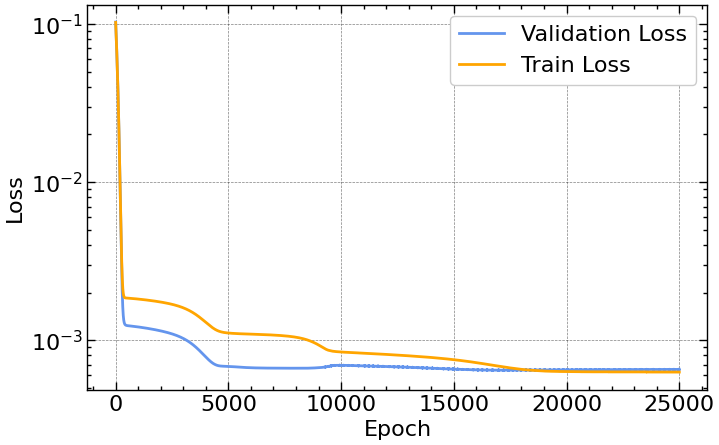

In [39]:
# ---------------------------------
# 4. Ploting Train vs Test Loss
# ---------------------------------
plt.figure(figsize=(8, 5))
plt.yscale("log")
plt.plot(np.linspace(0, len(test_losses_N4_PT), len(test_losses_N4_PT)), test_losses_N4_PT, label="Validation Loss", color = "cornflowerblue")
plt.plot(np.linspace(0, len(train_losses_N4_PT), len(train_losses_N4_PT)), train_losses_N4_PT, label="Train Loss", color = "orange")
plt.xticks(ticks=range(0, len(test_losses_N4_PT)+1, 5000))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation & Metrics

In [40]:
#------------------------------------
# 5. Evaluating the model
#------------------------------------

FFNN4_PT.eval()

with torch.no_grad():
    eta_tm_train_pred = FFNN4_PT(torch.cat((omegat_train_norm_tensor, Tem_train_norm_tensor, Pi_t_train_norm_tensor), dim=1)).numpy()
    eta_tm_test_pred = FFNN4_PT(torch.cat((omegat_test_norm_tensor, Tem_test_norm_tensor, Pi_t_test_norm_tensor), dim=1)).numpy()
    eta_tm_eval_pred = FFNN4_PT(torch.cat((omegat_eval_norm_tensor, Tem_eval_norm_tensor, Pi_t_eval_norm_tensor), dim=1)).numpy()

y_train_true_eta_tm = eta_tm_train_clean
y_val_true_eta_tm = eta_tm_eval_clean
y_test_true_eta_tm = eta_tm_test_clean

train_l2_eta_tm = relative_L2_error(eta_tm_train_pred, y_train_true_eta_tm)
train_r2_eta_tm = r2_score(y_train_true_eta_tm, eta_tm_train_pred)
train_mse_eta_tm = mean_squared_error(y_train_true_eta_tm, eta_tm_train_pred)

eval_l2_eta_tm = relative_L2_error(eta_tm_eval_pred, y_val_true_eta_tm)
eval_r2_eta_tm = r2_score(y_val_true_eta_tm, eta_tm_eval_pred)
eval_mse_eta_tm = mean_squared_error(y_val_true_eta_tm, eta_tm_eval_pred)

test_l2_eta_tm = relative_L2_error(eta_tm_test_pred, y_test_true_eta_tm)
test_r2_eta_tm = r2_score(y_test_true_eta_tm, eta_tm_test_pred)
test_mse_eta_tm = mean_squared_error(y_test_true_eta_tm, eta_tm_test_pred)

print(f"\n Metrics for eta_tm:")
print(f"Train: R² = {train_r2_eta_tm:.4f}, MSE = {train_mse_eta_tm:.2e}, L2 = {train_l2_eta_tm:.4f}")
print(f"Test:  R² = {test_r2_eta_tm:.4f}, MSE = {test_mse_eta_tm:.2e}, L2 = {test_l2_eta_tm:.4f}")
print(f"Evaluation:  R² = {eval_r2_eta_tm:.4f}, MSE = {eval_mse_eta_tm:.2e}, L2 = {eval_l2_eta_tm:.4f}")


 Metrics for eta_tm:
Train: R² = 0.9009, MSE = 1.26e-04, L2 = 2.3026
Test:  R² = 0.8346, MSE = 1.08e-04, L2 = 0.8214
Evaluation:  R² = 0.8860, MSE = 1.13e-04, L2 = 0.9718


C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\329511518.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, eta_tm_eval_pred, 'k--', color = 'red',  label='Prediction')


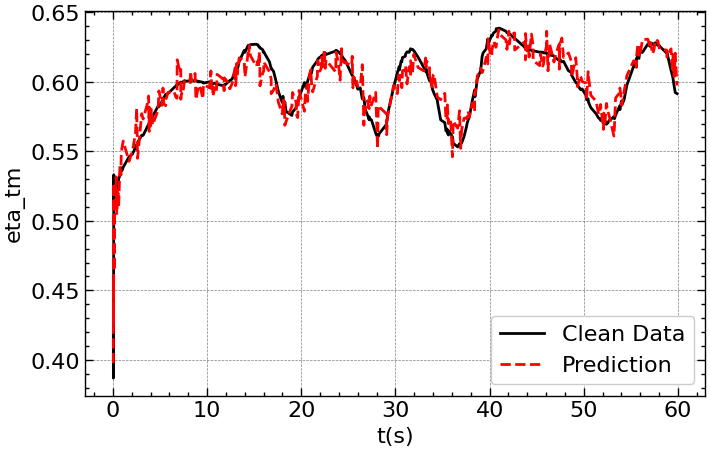

In [41]:
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(time_eval, eta_tm_eval_clean, color = 'black', label='Clean Data')
plt.plot(time_eval, eta_tm_eval_pred, 'k--', color = 'red',  label='Prediction')
#plt.plot(time, eta_tm_analytical, 'g', label = "Analytical Form")
plt.xlabel('t(s)')
plt.ylabel('eta_tm')
plt.legend()
plt.grid(True)
plt.show()

## $N_5^{(P)}(x; \theta_5^P) - \eta_{\mathit{c}}$

### Training Process

In [42]:
#---------------------------------------------------
# 1. Defining the Pre-Trained Neural Network N3
#---------------------------------------------------
class FFNN5(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

torch.manual_seed(123)
FFNN5_PT = FFNN5(2, 1, 4)

#------------------------------------------
# 2. Loss Function & Optimiser
#------------------------------------------
def NN5_PT_loss(model, x1_data, x2_data, y_data):
    x_combined = torch.cat((x1_data, x2_data), dim=1)  # Concatenating inputs
    y_pred = model(x_combined)
    return torch.mean((y_data - y_pred)**2)

optimiser_N5_PT = optim.Adam(FFNN5_PT.parameters(), lr=0.001)

#-----------------------------------
# 3. Training Loop
#-----------------------------------
num_epochs_N5_PT = 15000
print_every_N5_PT = 1000
early_stop_patience_N5_PT = 10000  # epochs to wait for improvement

train_losses_N5_PT = []
test_losses_N5_PT = []

best_test_loss = float('inf')
epochs_no_improve = 0

FFNN5_PT.train()
for epoch in range(num_epochs_N5_PT):
    optimiser_N5_PT.zero_grad()
    train_loss_NN5_PT = NN5_PT_loss(FFNN5_PT, Wc_train_norm_tensor, Pi_c_train_norm_tensor, eta_c_train_tensor)
    train_losses_N5_PT.append(train_loss_NN5_PT.item())
    train_loss_NN5_PT.backward()
    optimiser_N5_PT.step()

    FFNN5_PT.eval()
    with torch.no_grad():
        test_loss_NN5_PT = NN5_PT_loss(FFNN5_PT, Wc_test_norm_tensor, Pi_c_test_norm_tensor, eta_c_test_tensor)
        test_losses_N5_PT.append(test_loss_NN5_PT.item())

    FFNN5_PT.train()  # Switching back to training mode

    if test_loss_NN5_PT.item() < best_test_loss:
        best_test_loss = test_loss_NN5_PT.item()
        epochs_no_improve = 0
        best_model_wts = FFNN5_PT.state_dict()
    else:
        epochs_no_improve += 1

    if (epoch+1) % print_every_N5_PT == 0:
        print(f"Epoch {epoch+1}/{num_epochs_N5_PT}, "
              f"Train Loss = {train_loss_NN5_PT.item():.2e}, "
              f"Test Loss = {test_loss_NN5_PT.item():.2e}")

    if epochs_no_improve >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}. No improvement for {early_stop_patience} epochs.")
        break

FFNN5_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best test loss: {best_test_loss:.2e}")

Epoch 1000/15000, Train Loss = 1.59e-03, Test Loss = 6.15e-04
Epoch 2000/15000, Train Loss = 1.56e-03, Test Loss = 6.00e-04
Epoch 3000/15000, Train Loss = 1.53e-03, Test Loss = 5.85e-04
Epoch 4000/15000, Train Loss = 1.46e-03, Test Loss = 5.54e-04
Epoch 5000/15000, Train Loss = 8.27e-04, Test Loss = 3.46e-04
Epoch 6000/15000, Train Loss = 3.56e-04, Test Loss = 2.87e-04
Epoch 7000/15000, Train Loss = 3.06e-04, Test Loss = 2.71e-04
Epoch 8000/15000, Train Loss = 3.04e-04, Test Loss = 2.71e-04
Epoch 9000/15000, Train Loss = 3.03e-04, Test Loss = 2.71e-04
Epoch 10000/15000, Train Loss = 3.03e-04, Test Loss = 2.71e-04
Epoch 11000/15000, Train Loss = 3.02e-04, Test Loss = 2.71e-04
Epoch 12000/15000, Train Loss = 3.02e-04, Test Loss = 2.71e-04
Epoch 13000/15000, Train Loss = 3.01e-04, Test Loss = 2.71e-04
Epoch 14000/15000, Train Loss = 3.00e-04, Test Loss = 2.72e-04
Epoch 15000/15000, Train Loss = 2.99e-04, Test Loss = 2.73e-04
Training complete. Best test loss: 2.70e-04


### Training vs Validation Loss

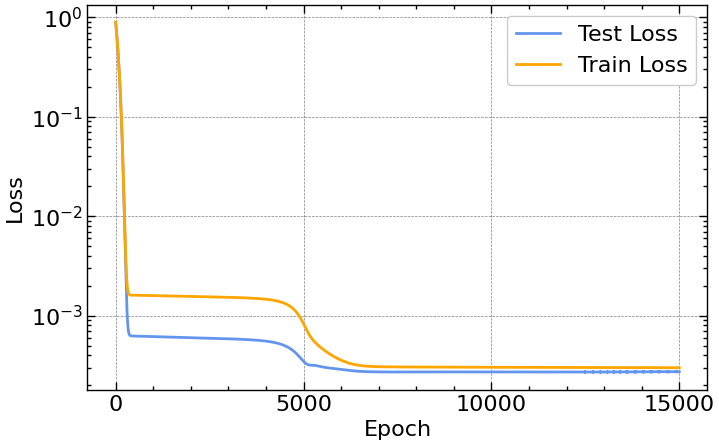

In [43]:
# ---------------------------------
# 4. Ploting Train vs Test Loss
# ---------------------------------
plt.figure(figsize=(8, 5))
plt.yscale("log")
plt.plot(np.linspace(0, len(test_losses_N5_PT), len(test_losses_N5_PT)), test_losses_N5_PT, label="Test Loss", color = "cornflowerblue")
plt.plot(np.linspace(0, len(test_losses_N5_PT), len(train_losses_N5_PT)), train_losses_N5_PT, label="Train Loss", color = "orange")
plt.xticks(ticks=range(0, len(test_losses_N5_PT)+1, 5000))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation & Metrics

In [44]:
#------------------------------------
# 5. Evaluating the model
#------------------------------------

FFNN5_PT.eval()

with torch.no_grad():
    eta_c_train_pred = FFNN5_PT(torch.cat((Wc_train_norm_tensor, Pi_c_train_norm_tensor), dim=1)).numpy()
    eta_c_test_pred = FFNN5_PT(torch.cat((Wc_test_norm_tensor, Pi_c_test_norm_tensor), dim=1)).numpy()
    eta_c_eval_pred = FFNN5_PT(torch.cat((Wc_eval_norm_tensor, Pi_c_eval_norm_tensor), dim=1)).numpy()  

y_train_true_eta_c = eta_c_train_clean
y_test_true_eta_c = eta_c_test_clean
y_eval_true_eta_c = eta_c_eval_clean

train_l2_eta_c = relative_L2_error(y_train_true_eta_c, eta_c_train_pred)
train_r2_eta_c = r2_score(y_train_true_eta_c, eta_c_train_pred)
train_mse_eta_c = mean_squared_error(y_train_true_eta_c, eta_c_train_pred)

test_l2_eta_c = relative_L2_error(y_test_true_eta_c, eta_c_test_pred)
test_r2_eta_c = r2_score(y_test_true_eta_c, eta_c_test_pred)
test_mse_eta_c = mean_squared_error(y_test_true_eta_c, eta_c_test_pred)

eval_l2_eta_c = relative_L2_error(y_eval_true_eta_c, eta_c_eval_pred)
eval_r2_eta_c = r2_score(y_eval_true_eta_c, eta_c_eval_pred)
eval_mse_eta_c = mean_squared_error(y_eval_true_eta_c, eta_c_eval_pred)

print(f"\n Metrics for eta_c:")
print(f"Train: R² = {train_r2_eta_c:.4f}, MSE = {train_mse_eta_c:.2e}, L2={train_l2_eta_c:.2e}")
print(f"Test:  R² = {test_r2_eta_c:.4f}, MSE = {test_mse_eta_c:.2e}, L2={test_l2_eta_c:.2e}")
print(f"Evaluation:  R² = {eval_r2_eta_c:.4f}, MSE = {eval_mse_eta_c:.2e}, L2={eval_l2_eta_c:.2e}")


 Metrics for eta_c:
Train: R² = 0.9656, MSE = 4.45e-05, L2=2.02e+00
Test:  R² = 0.9074, MSE = 3.59e-05, L2=5.54e-01
Evaluation:  R² = 0.9560, MSE = 4.53e-05, L2=8.58e-01


C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\1992846337.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, eta_c_eval_pred, 'k--', color = 'red',  label='Prediction')


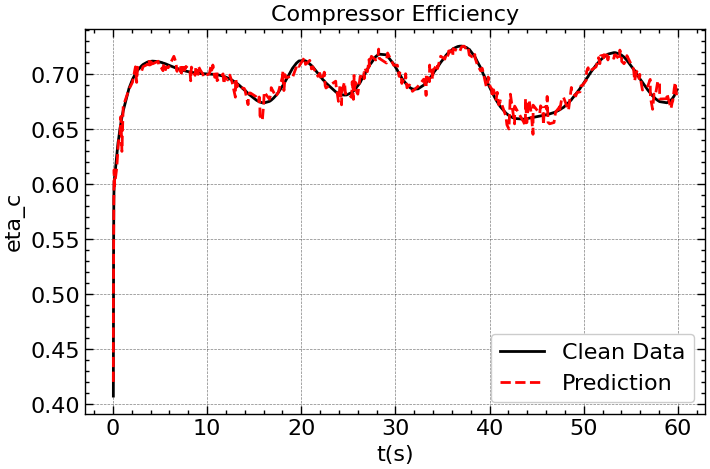

In [45]:
# Plotting results
plt.figure(figsize=(8, 5))
#plt.plot(time, eta_c_analytical, 'g', label = "Analytical Form", linestyle='--', linewidth=6)
plt.plot(time_eval, eta_c_eval_clean, color = 'black', label='Clean Data')
plt.plot(time_eval, eta_c_eval_pred, 'k--', color = 'red',  label='Prediction')
plt.xlabel('t(s)')
plt.ylabel('eta_c')
plt.title('Compressor Efficiency')
plt.legend()
plt.grid(True)
plt.show()

## $N_6^{(P)}(x; \theta_6^P) - Φ_c$

In [46]:
Tamb_train_tensor = torch.full((len(df_empirical_data_inputs_training['Time']), 1), Tamb).view(-1,1)
Tamb_test_tensor = torch.full((len(df_empirical_data_inputs_testing['Time']), 1), Tamb).view(-1,1)
Tamb_eval_tensor = torch.full((len(df_empirical_data_inputs_eval['Time']), 1), Tamb).view(-1,1)

In [47]:
def normalize_tensor_0_1(tensor):
    """
    Normalizes a PyTorch tensor to the range [0, 1].

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Normalized tensor.
    """
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val + 1e-8)

In [48]:
Tamb_train_norm_tensor = normalize_tensor_0_1(Tamb_train_tensor).view(-1, 1)
Tamb_test_norm_tensor = normalize_tensor_0_1(Tamb_test_tensor).view(-1, 1)
Tamb_eval_norm_tensor = normalize_tensor_0_1(Tamb_eval_tensor).view(-1, 1)

### Training Process

In [49]:
#---------------------------------------------------
# 1. Defining the Pre-Trained Neural Network N3
#---------------------------------------------------
class FFNN6(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_tranformation = nn.Sigmoid()
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        return self.output_tranformation(x)

torch.manual_seed(123)
FFNN6_PT = FFNN6(3, 1, 12)

#------------------------------------------
# 2. Loss Function & Optimiser
#------------------------------------------
def NN6_PT_loss(model, x1_data, x2_data, x3_data, y_data):
    x_combined = torch.cat((x1_data, x2_data, x3_data), dim=1)  # Concatenate inputs
    y_pred = model(x_combined)

    return torch.mean((y_data - y_pred)**2)

optimiser_N6_PT = optim.Adam(FFNN6_PT.parameters(), lr=0.004)


#-----------------------------------
# 3. Training Loop
#-----------------------------------
num_epochs_N6_PT = 35000
print_every_N6_PT = 1000
early_stop_patience = 8000  # epochs to wait for improvement

train_losses_N6_PT = []
test_losses_N6_PT = []

best_test_loss = float('inf')
epochs_no_improve = 0

FFNN6_PT.train()
for epoch in range(num_epochs_N6_PT):
    optimiser_N6_PT.zero_grad()
    train_loss_NN6_PT = NN6_PT_loss(FFNN6_PT, Tamb_train_norm_tensor, Pi_c_train_norm_tensor, omegat_train_norm_tensor, Phi_c_train_tensor)
    train_losses_N6_PT.append(train_loss_NN6_PT.item())
    train_loss_NN6_PT.backward()
    optimiser_N6_PT.step()

    FFNN6_PT.eval()
    with torch.no_grad():
        test_loss_NN6_PT = NN6_PT_loss(FFNN6_PT, Tamb_test_norm_tensor, Pi_c_test_norm_tensor, omegat_test_norm_tensor, Phi_c_test_tensor)
        test_losses_N6_PT.append(test_loss_NN6_PT.item())

    FFNN6_PT.train()  # Switching back to training mode

    if test_loss_NN6_PT.item() < best_test_loss:
        best_test_loss = test_loss_NN6_PT.item()
        epochs_no_improve = 0
        best_model_wts = FFNN6_PT.state_dict()  
    else:
        epochs_no_improve += 1

    if (epoch+1) % print_every_N6_PT == 0:
        print(f"Epoch {epoch+1}/{num_epochs_N6_PT}, "
              f"Train Loss = {train_loss_NN6_PT.item():.2e}, "
              f"Test Loss = {test_loss_NN6_PT.item():.2e}")
        
    if epochs_no_improve >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}. No improvement for {early_stop_patience} epochs.")
        break

FFNN6_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best test loss: {best_test_loss:.2e}")

Epoch 1000/35000, Train Loss = 5.65e-05, Test Loss = 4.61e-05
Epoch 2000/35000, Train Loss = 4.81e-05, Test Loss = 4.49e-05
Epoch 3000/35000, Train Loss = 4.30e-05, Test Loss = 4.46e-05
Epoch 4000/35000, Train Loss = 4.19e-05, Test Loss = 4.40e-05
Epoch 5000/35000, Train Loss = 3.55e-05, Test Loss = 3.46e-05
Epoch 6000/35000, Train Loss = 3.44e-05, Test Loss = 3.08e-05
Epoch 7000/35000, Train Loss = 3.26e-05, Test Loss = 3.06e-05
Epoch 8000/35000, Train Loss = 3.22e-05, Test Loss = 3.00e-05
Epoch 9000/35000, Train Loss = 3.13e-05, Test Loss = 2.85e-05
Epoch 10000/35000, Train Loss = 3.05e-05, Test Loss = 2.79e-05
Epoch 11000/35000, Train Loss = 2.96e-05, Test Loss = 2.73e-05
Epoch 12000/35000, Train Loss = 2.93e-05, Test Loss = 2.72e-05
Epoch 13000/35000, Train Loss = 2.87e-05, Test Loss = 2.66e-05
Epoch 14000/35000, Train Loss = 2.90e-05, Test Loss = 2.68e-05
Epoch 15000/35000, Train Loss = 2.79e-05, Test Loss = 2.65e-05
Epoch 16000/35000, Train Loss = 2.82e-05, Test Loss = 2.67e-05
E

### Train vs Validation Loss

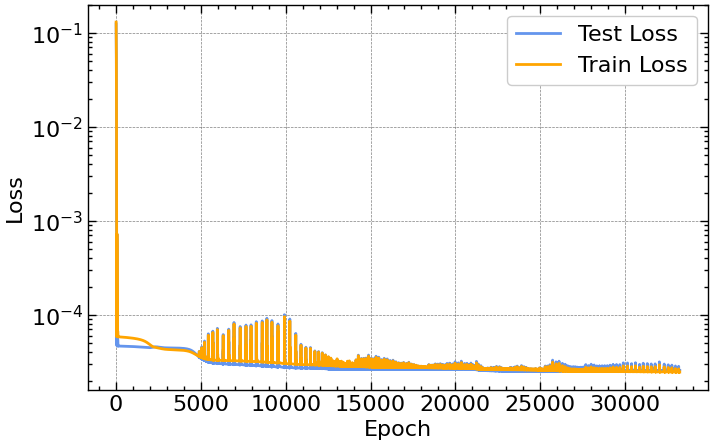

In [50]:
# ---------------------------------
# 4. Ploting Train vs Test Loss
# ---------------------------------
plt.figure(figsize=(8, 5))
plt.yscale("log")
plt.plot(np.linspace(0, len(test_losses_N6_PT), len(test_losses_N6_PT)), test_losses_N6_PT, label="Test Loss", color = "cornflowerblue")
plt.plot(np.linspace(0, len(test_losses_N6_PT), len(train_losses_N6_PT)), train_losses_N6_PT, label="Train Loss", color = "orange")
plt.xticks(ticks=range(0, len(test_losses_N6_PT)+1, 5000))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Metrics & Evaluation

In [51]:
#------------------------------------
# 5. Evaluating the model
#------------------------------------

FFNN6_PT.eval()

with torch.no_grad():
    Phi_c_train_pred = FFNN6_PT(torch.cat((Tamb_train_norm_tensor, Pi_c_train_norm_tensor, omegat_train_norm_tensor), dim=1)).numpy()
    Phi_c_test_pred = FFNN6_PT(torch.cat((Tamb_test_norm_tensor, Pi_c_test_norm_tensor, omegat_test_norm_tensor), dim=1)).numpy() 
    Phi_c_eval_pred = FFNN6_PT(torch.cat((Tamb_eval_norm_tensor, Pi_c_eval_norm_tensor, omegat_eval_norm_tensor), dim=1)).numpy() 
    
y_train_true_Phi_c = Phi_c_train_clean
y_test_true_Phi_c = Phi_c_test_clean
y_eval_true_Phi_c = Phi_c_eval_clean

train_l2_Phi_c = relative_L2_error(y_train_true_Phi_c, Phi_c_train_pred)
train_r2_Phi_c = r2_score(y_train_true_Phi_c, Phi_c_train_pred)
train_mse_Phi_c = mean_squared_error(y_train_true_Phi_c, Phi_c_train_pred)

test_l2_Phi_c = relative_L2_error(y_test_true_Phi_c, Phi_c_test_pred)
test_r2_Phi_c = r2_score(y_test_true_Phi_c, Phi_c_test_pred)
test_mse_Phi_c = mean_squared_error(y_test_true_Phi_c, Phi_c_test_pred)

eval_l2_Phi_c = relative_L2_error(y_eval_true_Phi_c, Phi_c_eval_pred)
eval_r2_Phi_c = r2_score(y_eval_true_Phi_c, Phi_c_eval_pred)
eval_mse_Phi_c = mean_squared_error(y_eval_true_Phi_c, Phi_c_eval_pred)

print(f"\n Metrics for Fc:")
print(f"Train: R² = {train_r2_Phi_c:.4f}, MSE = {train_mse_Phi_c:.2e}, L2 = {train_l2_Phi_c:.2e}")
print(f"Test:  R² = {test_r2_Phi_c:.4f}, MSE = {test_mse_Phi_c:.2e}, L2 = {test_l2_Phi_c:.2e}")
print(f"Evaluation:  R² = {eval_r2_Phi_c:.4f}, MSE = {eval_mse_Phi_c:.2e}, L2 = {eval_l2_Phi_c:.2e}")


 Metrics for Fc:
Train: R² = 0.6454, MSE = 1.95e-05, L2 = 1.83e+00
Test:  R² = 0.5183, MSE = 1.96e-05, L2 = 7.92e-01
Evaluation:  R² = 0.5537, MSE = 2.42e-05, L2 = 8.69e-01


C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\3746611282.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, Phi_c_eval_pred, 'k--', color = 'red',  label='Prediction')


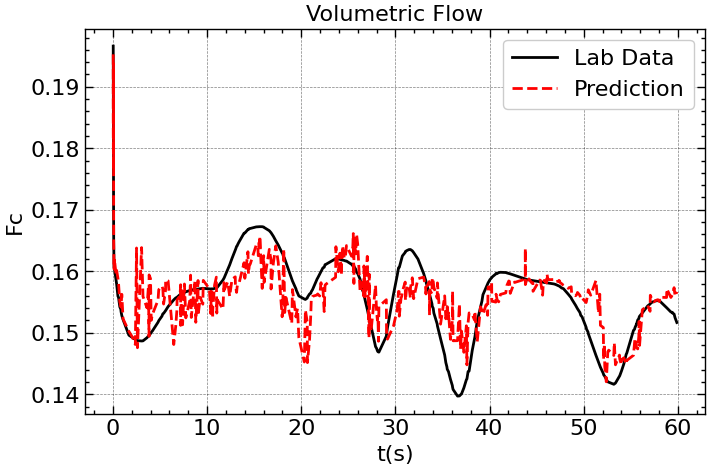

In [52]:
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(time_eval, Phi_c_eval_clean, color = 'black', label='Lab Data')
plt.plot(time_eval, Phi_c_eval_pred, 'k--', color = 'red',  label='Prediction')
plt.xlabel('t(s)')
plt.ylabel('Fc')
plt.title('Volumetric Flow')
plt.legend()
plt.grid(True)
plt.show()

# Metrics

In [53]:
# Define consistent column widths
col_widths = [10, 12] + [12] * 6  # Dataset, Noise Level, then 6 variables

# Helper for separator
line_sep = "|" + "|".join(["-" * (w + 2) for w in col_widths]) + "|"

# --------------------------------
# MSE Table
# --------------------------------
print(f"| {'Dataset':^{col_widths[0]}} | {'Noise Level':^{col_widths[1]}} | "
      f"{'eta_vol':^{col_widths[2]}} | {'fegr':^{col_widths[3]}} | {'Fvgt':^{col_widths[4]}} | "
      f"{'eta_c':^{col_widths[5]}} | {'eta_tm':^{col_widths[6]}} | {'F_c':^{col_widths[7]}} |")
print(line_sep)
print(f"| {'MSE':^{col_widths[0]}} | {'':^{col_widths[1]}} | "
      f"{'':^{col_widths[2]}} | {'':^{col_widths[3]}} | {'':^{col_widths[4]}} | "
      f"{'':^{col_widths[5]}} | {'':^{col_widths[6]}} | {'':^{col_widths[7]}} |")

print(f"| {'Training':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{train_mse_eta_vol:^{col_widths[2]}.2e} | "
      f"{train_mse_fegr:^{col_widths[3]}.2e} | "
      f"{train_mse_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{train_mse_eta_c:^{col_widths[5]}.2e} | "
      f"{train_mse_eta_tm:^{col_widths[6]}.2e} | "
      f"{train_mse_Phi_c:^{col_widths[7]}.2e} |")

print(f"| {'Testing':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{test_mse_eta_vol:^{col_widths[2]}.2e} | "
      f"{test_mse_fegr:^{col_widths[3]}.2e} | "
      f"{test_mse_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{test_mse_eta_c:^{col_widths[5]}.2e} | "
      f"{test_mse_eta_tm:^{col_widths[6]}.2e} | "
      f"{test_mse_Phi_c:^{col_widths[7]}.2e} |")

print(f"| {'Evaluation':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{eval_mse_eta_vol:^{col_widths[2]}.2e} | "
      f"{eval_mse_fegr:^{col_widths[3]}.2e} | "
      f"{eval_mse_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{eval_mse_eta_c:^{col_widths[5]}.2e} | "
      f"{eval_mse_eta_tm:^{col_widths[6]}.2e} | "
      f"{eval_mse_Phi_c:^{col_widths[7]}.2e} |")

print()
print()

# --------------------------------
# R2 Table
# --------------------------------
print(f"| {'Dataset':^{col_widths[0]}} | {'Noise Level':^{col_widths[1]}} | "
      f"{'eta_vol':^{col_widths[2]}} | {'fegr':^{col_widths[3]}} | {'Fvgt':^{col_widths[4]}} | "
      f"{'eta_c':^{col_widths[5]}} | {'eta_tm':^{col_widths[6]}} | {'F_c':^{col_widths[7]}} |")
print(line_sep)
print(f"| {'R2':^{col_widths[0]}} | {'':^{col_widths[1]}} | "
      f"{'':^{col_widths[2]}} | {'':^{col_widths[3]}} | {'':^{col_widths[4]}} | "
      f"{'':^{col_widths[5]}} | {'':^{col_widths[6]}} | {'':^{col_widths[7]}} |")

print(f"| {'Training':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{train_r2_eta_vol:^{col_widths[2]}.2e} | "
      f"{train_r2_fegr:^{col_widths[3]}.2e} | "
      f"{train_r2_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{train_r2_eta_c:^{col_widths[5]}.2e} | "
      f"{train_r2_eta_tm:^{col_widths[6]}.2e} | "
      f"{train_r2_Phi_c:^{col_widths[7]}.2e} |")

print(f"| {'Testing':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{test_r2_eta_vol:^{col_widths[2]}.2e} | "
      f"{test_r2_fegr:^{col_widths[3]}.2e} | "
      f"{test_r2_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{test_r2_eta_c:^{col_widths[5]}.2e} | "
      f"{test_r2_eta_tm:^{col_widths[6]}.2e} | "
      f"{test_r2_Phi_c:^{col_widths[7]}.2e} |")

print(f"| {'Evaluation':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{eval_r2_eta_vol:^{col_widths[2]}.2e} | "
      f"{eval_r2_fegr:^{col_widths[3]}.2e} | "
      f"{eval_r2_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{eval_r2_eta_c:^{col_widths[5]}.2e} | "
      f"{eval_r2_eta_tm:^{col_widths[6]}.2e} | "
      f"{eval_r2_Phi_c:^{col_widths[7]}.2e} |")

print()
print()
# --------------------------------
# L2 Table
# --------------------------------
print(f"| {'Dataset':^{col_widths[0]}} | {'Noise Level':^{col_widths[1]}} | "
      f"{'eta_vol':^{col_widths[2]}} | {'fegr':^{col_widths[3]}} | {'Fvgt':^{col_widths[4]}} | "
      f"{'eta_c':^{col_widths[5]}} | {'eta_tm':^{col_widths[6]}} | {'F_c':^{col_widths[7]}} |")
print(line_sep)
print(f"| {'L2':^{col_widths[0]}} | {'':^{col_widths[1]}} | "
      f"{'':^{col_widths[2]}} | {'':^{col_widths[3]}} | {'':^{col_widths[4]}} | "
      f"{'':^{col_widths[5]}} | {'':^{col_widths[6]}} | {'':^{col_widths[7]}} |")

print(f"| {'Training':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{train_l2_eta_vol:^{col_widths[2]}.2e} | "
      f"{train_l2_fegr:^{col_widths[3]}.2e} | "
      f"{train_l2_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{train_l2_eta_c:^{col_widths[5]}.2e} | "
      f"{train_l2_eta_tm:^{col_widths[6]}.2e} | "
      f"{train_l2_Phi_c:^{col_widths[7]}.2e} |")

print(f"| {'Testing':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{test_l2_eta_vol:^{col_widths[2]}.2e} | "
      f"{test_l2_fegr:^{col_widths[3]}.2e} | "
      f"{test_l2_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{test_l2_eta_c:^{col_widths[5]}.2e} | "
      f"{test_l2_eta_tm:^{col_widths[6]}.2e} | "
      f"{test_l2_Phi_c:^{col_widths[7]}.2e} |")

print(f"| {'Evaluation':^{col_widths[0]}} | {'3%':^{col_widths[1]}} | "
      f"{eval_l2_eta_vol:^{col_widths[2]}.2e} | "
      f"{eval_l2_fegr:^{col_widths[3]}.2e} | "
      f"{eval_l2_fvgt_Pit:^{col_widths[4]}.2e} | "
      f"{eval_l2_eta_c:^{col_widths[5]}.2e} | "
      f"{eval_l2_eta_tm:^{col_widths[6]}.2e} | "
      f"{eval_l2_Phi_c:^{col_widths[7]}.2e} |")



|  Dataset   | Noise Level  |   eta_vol    |     fegr     |     Fvgt     |    eta_c     |    eta_tm    |     F_c      |
|------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|
|    MSE     |              |              |              |              |              |              |              |
|  Training  |      3%      |   3.79e-07   |   7.35e-04   |   1.71e-04   |   4.45e-05   |   1.26e-04   |   1.95e-05   |
|  Testing   |      3%      |   3.83e-07   |   4.78e-04   |   1.29e-04   |   3.59e-05   |   1.08e-04   |   1.96e-05   |
| Evaluation |      3%      |   4.16e-07   |   5.41e-04   |   2.20e-04   |   4.53e-05   |   1.13e-04   |   2.42e-05   |


|  Dataset   | Noise Level  |   eta_vol    |     fegr     |     Fvgt     |    eta_c     |    eta_tm    |     F_c      |
|------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|
|     R2     |              |         

# Plots

## $\eta_{vol}$

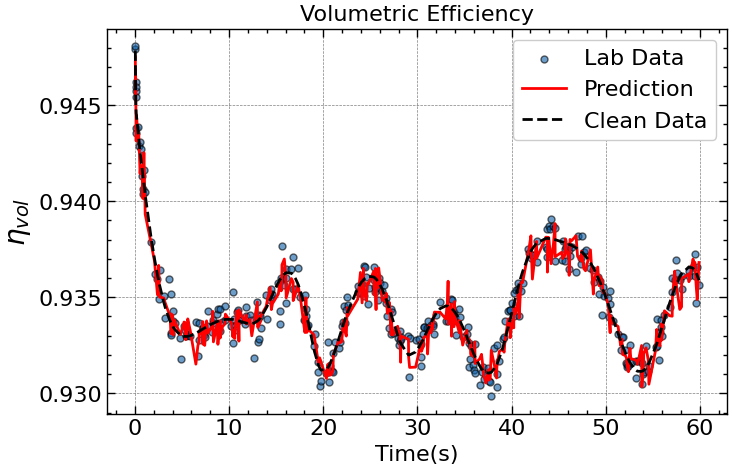

In [54]:
plt.figure(figsize=(8, 5))
plt.scatter(time_eval, eta_vol_eval, s=25, alpha = 0.6, edgecolors='black',label = "Lab Data")
plt.plot(time_eval, eta_vol_eval_pred,  color = 'red',  label='Prediction')
plt.plot(time_eval, eta_vol_eval_clean, color = 'black', label='Clean Data', linestyle = '--')
plt.xlabel('Time(s)')
plt.ylabel(r'$\eta_{vol}$', fontsize = 20)
plt.title("Volumetric Efficiency")
plt.legend()
plt.grid(True)
plt.show()


## $f_{egr}$

C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\793433329.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, fegr_eval_clean, 'k--',color = 'black', label='Clean Data')


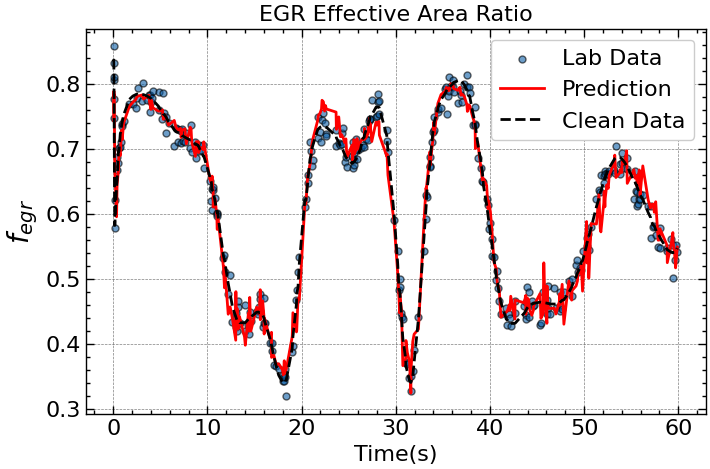

In [55]:
plt.figure(figsize=(8, 5))
plt.scatter(time_eval, fegr_eval, s=25, alpha = 0.6, edgecolors='black',label = "Lab Data")
plt.plot(time_eval, fegr_eval_pred,  color = 'red',  label='Prediction')
plt.plot(time_eval, fegr_eval_clean, 'k--',color = 'black', label='Clean Data')
plt.xlabel('Time(s)')
plt.ylabel(r'$f_{egr}$', fontsize = 20)
plt.title("EGR Effective Area Ratio")
plt.legend()
plt.grid(True)
plt.show()

## $F_{vgt, \Pi_{t}}$

C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\1741661046.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, F_vgt_Pi_t_eval_clean, "k--",color = 'black', label='Clean Data')


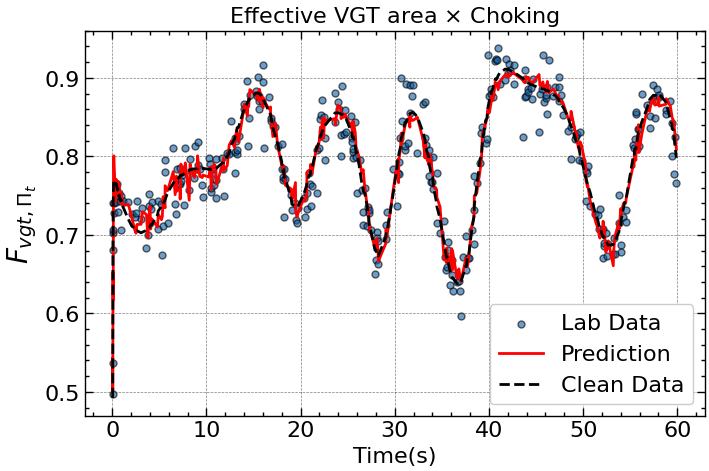

In [56]:
plt.figure(figsize=(8, 5))
plt.scatter(time_eval, F_vgt_Pi_t_eval, s=25, alpha = 0.6, edgecolors='black',label = "Lab Data")
plt.plot(time_eval, fvgt_Pit_eval_pred,  color = 'red',  label='Prediction')
plt.plot(time_eval, F_vgt_Pi_t_eval_clean, "k--",color = 'black', label='Clean Data')
plt.xlabel('Time(s)')
plt.ylabel(r'$F_{vgt,\Pi_t}$', fontsize = 20)
plt.title(r"Effective VGT area $\times$ Choking")
plt.legend()
plt.grid(True)
plt.show()

## $\eta_{tm}$

C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\942371227.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, eta_tm_eval_clean, "k--", color = 'black', label='Clean Data')


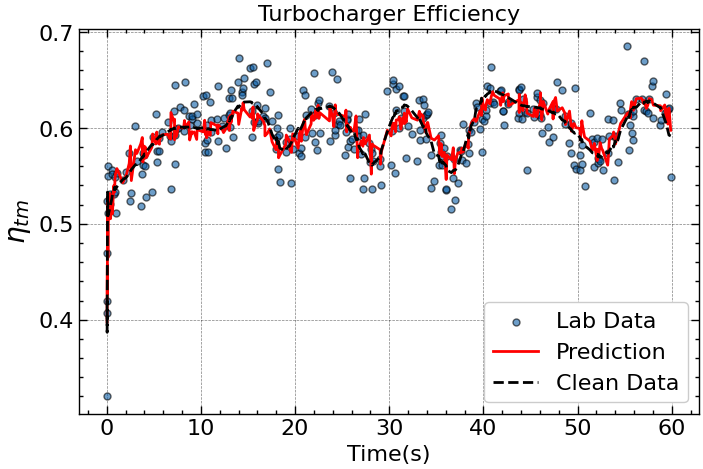

In [57]:
plt.figure(figsize=(8, 5))
plt.scatter(time_eval, eta_tm_eval, s=25, alpha = 0.6, edgecolors='black',label = "Lab Data")
plt.plot(time_eval, eta_tm_eval_pred,  color = 'red',  label='Prediction')
plt.plot(time_eval, eta_tm_eval_clean, "k--", color = 'black', label='Clean Data')
plt.xlabel('Time(s)')
plt.ylabel(r'$\eta_{tm}$', fontsize = 20)
plt.title("Turbocharger Efficiency")
plt.legend()
plt.grid(True)
plt.show()

## $\eta_{c}$

C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\2936299713.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, eta_c_eval_clean, "k--",color = 'black', label='Clean Data')


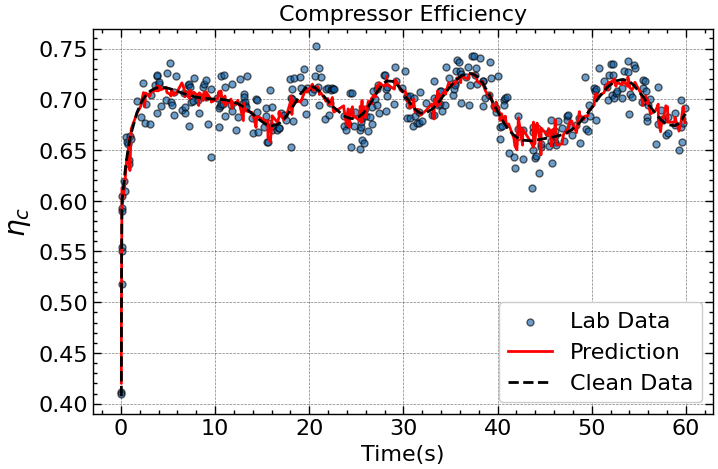

In [58]:
plt.figure(figsize=(8, 5))
plt.scatter(time_eval, eta_c_eval, s=25, alpha = 0.6, edgecolors='black',label = "Lab Data")
plt.plot(time_eval, eta_c_eval_pred,  color = 'red',  label='Prediction')
plt.plot(time_eval, eta_c_eval_clean, "k--",color = 'black', label='Clean Data')
plt.xlabel('Time(s)')
plt.ylabel(r'$\eta_{c}$', fontsize = 20)
plt.title("Compressor Efficiency")
plt.legend()
plt.grid(True)
plt.show()

## $\Phi_{c}$

C:\Users\dimka\AppData\Local\Temp\ipykernel_19348\3675267207.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(time_eval, Phi_c_eval_clean, "k--",color = 'black', label='Clean Data')


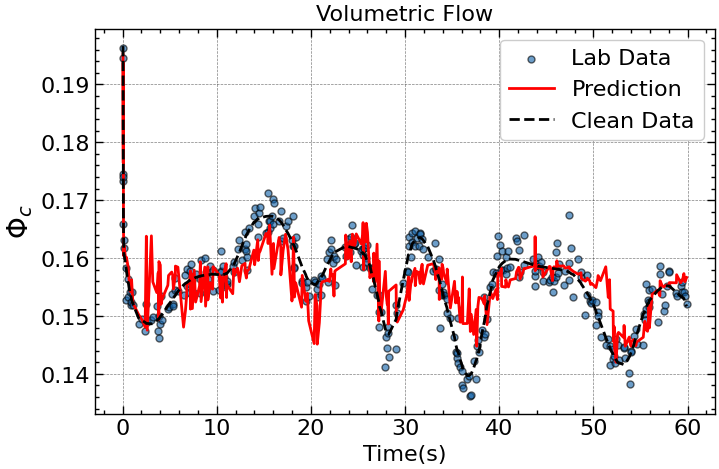

In [59]:
plt.figure(figsize=(8, 5))
plt.scatter(time_eval, Phi_c_eval, s=25, alpha = 0.6, edgecolors='black',label = "Lab Data")
plt.plot(time_eval, Phi_c_eval_pred,  color = 'red',  label='Prediction')
plt.plot(time_eval, Phi_c_eval_clean, "k--",color = 'black', label='Clean Data')
plt.xlabel('Time(s)')
plt.ylabel(r'$\Phi_{c}$', fontsize = 20)
plt.title("Volumetric Flow")
plt.legend()
plt.grid(True)
plt.show()